# JWST Science Calibration Pipeline Walkthrough

This notebook walks through how to install the JWST pipeline and reduce CV3 data. Each calibration step can be performed in the notebook, and arrays containing pixel values after each step get updated as calibration steps are performed. Each calibration step has its own section with figures, ramp plots, dq flag values, etc. The last section of the notebook looks at the final calibrated image. For this version, I use a CV3 data set. 

## Environment Setup

A working installation of Miniconda or Anaconda is required. It is best to do this on witserv, rather than taking up a lot of space on your local computer. Login in to one of the servers and set up your Astroconda environment. Most software (not the JWST pipeline) is in the "astroconda" channel. See the Astroconda installation page here:http://astroconda.readthedocs.io/en/latest/installation.html

If you need more detailed information on installing Conda, see the ST training page: https://stsci-riab.github.io/riatraining/computer_setup.html#installing-conda

Once you have that, you can install the JWST package. In your Conda environment, type:
    
        $ conda create -n <ENV_NAME> --file <URL>
    
        Where <ENV_NAME> is your name for the environment and <URL> depends on the version you want to install.
        To install the Build 7.1 pre-release that includes the Level 3 processing steps, use one of these URLs:
    
        Linux: http://ssb.stsci.edu/conda/jwstdp-0.7.8/jwstdp-0.7.8rc1-linux-py27.0.txt
        OS X: http://ssb.stsci.edu/conda/jwstdp-0.7.8/jwstdp-0.7.8rc1-osx-py27.0.txt
    
Now, activate your JWST calibration pipeline environment:

        $ source activate <ENV_NAME>
    
Because you are installing the Build 7.1 pre-release version, you must use the CRDS mapping file 0341 and greater (the CRDS map files tell the pipeline which reference files to grab):

        $ export CRDS_CONTEXT='jwst_0341.pmap'
    
        To see the general page for CRDS, go here: https://jwst-crds.stsci.edu
   
** To run the pipeline in this notebook, you must open the notebook from within your JWST calibration pipeline environment! "shift+enter" is the hot key to run a cell of the notebook. **   

## Import modules and functions

In [1]:
# JWST Pipeline Modules

from jwst.datamodels import RampModel
from jwst.dq_init import DQInitStep
from jwst.saturation import SaturationStep
from jwst.superbias import SuperBiasStep
from jwst.refpix import RefPixStep
from jwst.dark_current import DarkCurrentStep
from jwst.ipc import IPCStep
from jwst.linearity import LinearityStep
from jwst.jump import JumpStep
from jwst.ramp_fitting import RampFitStep
from jwst.flatfield import FlatFieldStep
from jwst.pipeline import Detector1Pipeline

# Import Plotting and Analysis Modules
from IPython.display import Image, display
import os
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import itertools
import numpy as np 
%matplotlib inline



# define some functions for easier plotting and analysis

# display image

def display_img(image, vmin, vmax):
    plt.figure(figsize=(20,20))
    plt.ylabel('y pixels',fontsize=22)
    plt.xlabel('x pixels',fontsize=22)
    plt.imshow(image, vmin = vmin, vmax=vmax, cmap=plt.cm.gray, origin='lower')
    plt.colorbar(orientation='horizontal',pad=0.05) 
    return plt


# define function for easier plotting of pixels

def plot_pixel(image, xpix, ypix, label, ax, color, ymin, ymax, xmin, xmax,mode):
    nframe = readpatts[mode.lower()]['nframe']
    nskip = readpatts[mode.lower()]['nskip']
    ngroup = readpatts[mode.lower()]['ngroup']
    tgroup = readpatts[mode.lower()]['tgroup']
    dataloc = (nframe+nskip)/2
    ax.plot(np.arange(dataloc,len(image)*(nframe+nskip)+dataloc,(nframe+nskip))*10.73676, image[:,ypix,xpix], label=label, marker='d',markersize=10, color=color)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin-tgroup,xmax*tgroup+tgroup)
    ax.legend(loc='best')
    return ax


# define function for easier plotting of ramps

def plot_ramp(image, xpix, ypix, title, label, ax, color, ymin, ymax, xmin, xmax,mode):
    nframe = readpatts[mode.lower()]['nframe']
    nskip = readpatts[mode.lower()]['nskip']
    ngroup = readpatts[mode.lower()]['ngroup']
    tgroup = readpatts[mode.lower()]['tgroup']    
    dataloc = (nframe+nskip)/2
    x_ramp =np.arange(dataloc,len(image)*(nframe+nskip)+dataloc,(nframe+nskip))*10.73676
    ax.plot(x_ramp, image[ypix,xpix]*x_ramp, label=label,lw=4,color=color)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin-tgroup,xmax*tgroup+tgroup)
    ax.legend(loc='best')
    return ax


# find saturated pixel by looking for pixel w/ signal level higher than some threshold (DN)
# e.g. jj,ii = find_sat_pix(image,60000)

def find_sat_pix(data,threshold):
    saturated = np.where(data > threshold)
    ii = saturated[2][0]
    jj = saturated[1][0]
    return jj, ii


# find cosmic rays by looking for pixels w/ signal differences higher given threshold (integer)
# e.g. nn,mm = find_cr_pix(image,5)

def find_cr_pix(data,threshold):
    coords = []
    readnoise = 16
    #loop over pixel coordinate combinations 
    # full array would be (0,2048)
    for i,j in itertools.product(np.arange(300,800), np.arange(300,800)):
        y = data[:,j,i]
        # this method is a simplified version of what the pipeline does
        ydiff = np.abs(np.diff(y))
        poisson_noise = np.sqrt(np.abs(ydiff))
        yerr_exp = np.sqrt(poisson_noise*poisson_noise + readnoise*readnoise)
        ratio = ydiff/yerr_exp
        candidate = ratio.argmax()
        if ratio[candidate] > threshold:
            coords.append([j,i])
        sample = random.sample(coords, 1)
    return sample[0][1],sample[0][0]


# find bad pixels by loading the appropriate bad pixel mask and choosing a pixel flagged as "bad"
# e.g. kk,ll = find_bad_pix("NRCA1_17004_BPM_ISIMCV3_2016-01-21_ssbspmask_DMSorient.fits")

def find_bad_pix(bpm):
    # bpm is the bad pixel mask that will be used for calibration of the file
    badpix = np.where(bpm == 5)
    mm = badpix[1][0]
    nn = badpix[0][1]
    return nn,mm


# NIRCam readmode dictionary for ramp values

deep8 = {}
deep8['tgroup'] = 212.
deep8['ngroup'] = 20.
deep8['nframe'] = 8
deep8['nskip'] = 12

deep2 = {}
deep2['tgroup'] = 212.
deep2['ngroup'] = 20.
deep2['nframe'] = 2
deep2['nskip'] = 18

medium8 = {}
medium8['tgroup'] = 106.
medium8['ngroup'] = 10.
medium8['nframe'] = 8
medium8['nskip'] = 2

medium2 = {}
medium2['tgroup'] = 106.
medium2['ngroup'] = 10.
medium2['nframe'] = 2
medium2['nskip'] = 8

shallow4 = {}
shallow4['tgroup'] = 53.
shallow4['ngroup'] = 10.
shallow4['nframe'] = 4
shallow4['nskip'] = 1

shallow2 = {}
shallow2['tgroup'] = 53.
shallow2['ngroup'] = 10.
shallow2['nframe'] = 2
shallow2['nskip'] = 3

bright2 = {}
bright2['tgroup'] = 21.2
bright2['ngroup'] = 10.
bright2['nframe'] = 2
bright2['nskip'] = 0

bright1 = {}
bright1['tgroup'] = 21.2
bright1['ngroup'] = 10.
bright1['nframe'] = 1
bright1['nskip'] = 1

rapid = {}
rapid['tgroup'] = 10.73676
rapid['ngroup'] = 10.
rapid['nframe'] = 1
rapid['nskip'] = 0

readpatts = {}
readpatts['deep8'] = deep8
readpatts['deep2'] = deep2
readpatts['medium8'] = medium8
readpatts['medium2'] = medium2
readpatts['shallow4'] = shallow4
readpatts['shallow2'] = shallow2
readpatts['bright2'] = bright2
readpatts['bright1'] = bright1
readpatts['rapid'] = rapid

## Get most updated JWST calibration pipeline cfg files

config files tell the pipeline how to run the pipeline steps. You can get them by typing in the command line:

        $ collect_pipeline_cfgs ./
        
The cell below runs this command and puts the cfg files in your directory.

In [4]:
cmd = "collect_pipeline_cfgs ./"
print("Running command:")
print(cmd)
print('in the command line.')
os.system(cmd) 

Running command:
collect_pipeline_cfgs ./
in the command line.


Some of these files need to be modified for NIRCam. Open ** refpix.cfg** in a text editor and you will see this:

        name = "refpix"
        class = "jwst.refpix.RefPixStep"
        odd_even_columns = True
        use_side_ref_pixels = True
        side_smoothing_length=11
        side_gain=1.0
        odd_even_rows = True
        
** Change odd_even_rows to False and save it. **

Now, open ** calwebb_detector1.cfg** and turn off the steps NIRCam doesn't need so the file looks like this:

        name = "Detector1Pipeline"
        class = "jwst.pipeline.Detector1Pipeline"
        save_calibrated_ramp = False

            [steps]
              [[group_scale]]
                skip = True
              [[dq_init]]
                config_file = dq_init.cfg
              [[saturation]]
                config_file = saturation.cfg
              [[ipc]]
                skip = True
              [[superbias]]
                config_file = superbias.cfg
              [[refpix]]
                config_file = refpix.cfg
              [[rscd]]
                skip = True
              [[lastframe]]
                skip = True
              [[linearity]]
                config_file = linearity.cfg
              [[dark_current]]
                config_file = dark_current.cfg
              [[persistence]]
                skip = True
              [[jump]]
                config_file = jump.cfg
              [[ramp_fit]]
                config_file = ramp_fit.cfg

## Check data formats

If the data is still in the FITSWriter format, it must be converted before it can go through the JWST calibration pipeline. Check the format of the data. 

** FITSWriter format (science data in the PRIMARY extension)**:

        In [6]: from astropy.io import fits
        In [7]: fits.info("NRCV82600049001P0000000002102.fits")
        Filename: NRCV82600049001P0000000002102.fits
        No.    Name         Type      Cards   Dimensions   Format
            0  PRIMARY     PrimaryHDU     381   (320, 320, 20) int16 (rescales to uint16)  
            1  ENG         BinTableHDU     15   78148R x 3C  [30A, 30A, 30A

**SSB format (science data in the SCI extension)**:

        In [1]: from astropy.io import fits 
        In [2]: fits.info("NRCNRCA1-DARK-60012216201_uncal.fits")
        Filename: NRCNRCA1-DARK-60012216201_uncal.fits
        No.    Name         Type      Cards   Dimensions   Format
              0  PRIMARY     PrimaryHDU     392   ()     
              1  SCI         ImageHDU        10   (2048, 2048, 108, 1)   float32  
              2  PIXELDQ     ImageHDU        10   (2048, 2048) int32 (rescales to uint32)  
              3  GROUPDQ     ImageHDU        10   (2048, 2048, 108, 1)   uint8  
              4  ERR         ImageHDU        10   (2048, 2048, 108, 1)   float32  
              5  ASDF        ImageHDU         7   (1811965775,)   uint8
              
If you need to change the format, we have scripts that do it for you in our https://github.com/spacetelescope/nircam_calib/ repository. The scripts are here https://github.com/spacetelescope/nircam_calib/tree/master/nircam_calib/tools/image_orientation. In your JWST calibration pipeline environment, type the following command:

        export UAZCONVDIR='/grp/jwst/wit/nircam/nircam-tools/pythonmodules/'     
        export JWSTTOOLS_PYTHONMODULES='$JWSTTOOLS_ROOTDIR/pythonmodules'       
        export JWSTTOOLS_ROOTDIR='/grp/jwst/wit/nircam/nircam-tools'       
        export JWSTTOOLS_INSTRUMENT='NIRCAM'        
        python sci2ssb.py <wrong_format.fits>
        
        where <wrong_format.fits> is the file that you need to reformat.

## Load and check the raw data file

Filename: NRCNRCA1-DARK-60012216201_1_481_SE_2016-01-02T02h34m28_uncal_sliced.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     392   ()      
  1  SCI         ImageHDU        10   (2048, 2048, 5, 1)   float32   
  2  PIXELDQ     ImageHDU        10   (2048, 2048)   int32 (rescales to uint32)   
  3  GROUPDQ     ImageHDU        10   (2048, 2048, 5, 1)   uint8   
  4  ERR         ImageHDU        10   (2048, 2048, 5, 1)   float32   
  5  ASDF        ImageHDU         7   (1811965775,)   uint8   


<module 'matplotlib.pyplot' from '/user/acanipe/miniconda3/envs/jwst71release/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

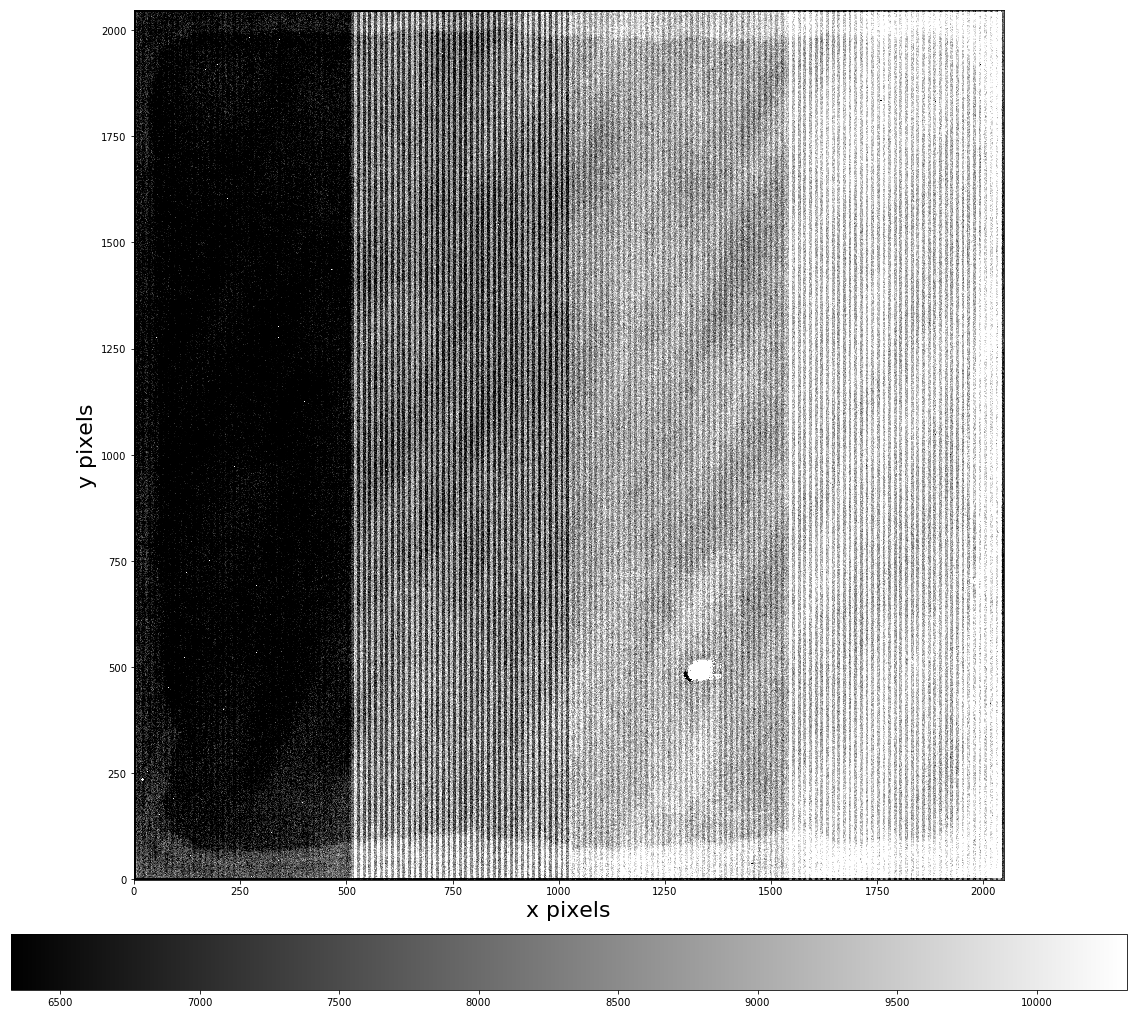

In [36]:
uncalFile = "NRCNRCA1-DARK-60012216201_1_481_SE_2016-01-02T02h34m28_uncal_sliced.fits"
fileBase = uncalFile[:-5]

# use astropy to access the data
with fits.open(uncalFile) as h:
    h.info()
    imageUncal = h[1].data
    imageUncal = imageUncal[0,:,:,:]
    pixeldq = h[2].data
    groupdq = h[3].data
    groupdq = groupdq[0,:,:,:]
    err = h[4].data
    err = err[0,:,:,:]
    ngroups = h[0].header['NGROUPS']
    det = h[0].header['DETECTOR']
    mode = h[0].header['READPATT']

# display the first group of the image 
# vmin/vmax match ds9 scale limits or the limits of the data
# use sigma_clipped_stats to get mean for image limits
mean,med,std = sigma_clipped_stats(imageUncal[0,:,:],sigma=3)
display_img(imageUncal[0,:,:],mean-2000,mean+2000)

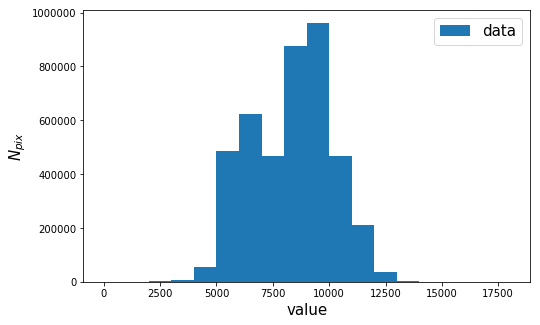

In [3]:
# make a histogram of the values in the first group
plt.figure(figsize=(8, 5))
bin_vals,bins,patches = plt.hist(np.ravel(imageUncal[0,:,:]),bins=np.arange(0,mean+10000,1000),range=(0,mean+10000),label='data')
plt.xlabel('value',fontsize=15)
plt.ylabel('$N_{pix}$',fontsize=15)
plt.legend(fontsize=15)

## Choose pixels to study throughout calibration steps

In [4]:
# look at weird pixels: peak of PSF (saturated), CRs, hot pixels, etc.
# ** note that python coords start from 0,0 and there is a 4 pixel wide border of reference pixels around the detector **

repx =  1124                                          # random pix x
repy = 358                                            # random pix y
# jj, ii = find_sat_pix(imageUncal,60000)             # saturated pix x, y
# ll, kk = find_cr_pix(imageUncal,3)                  # CR pix x, y

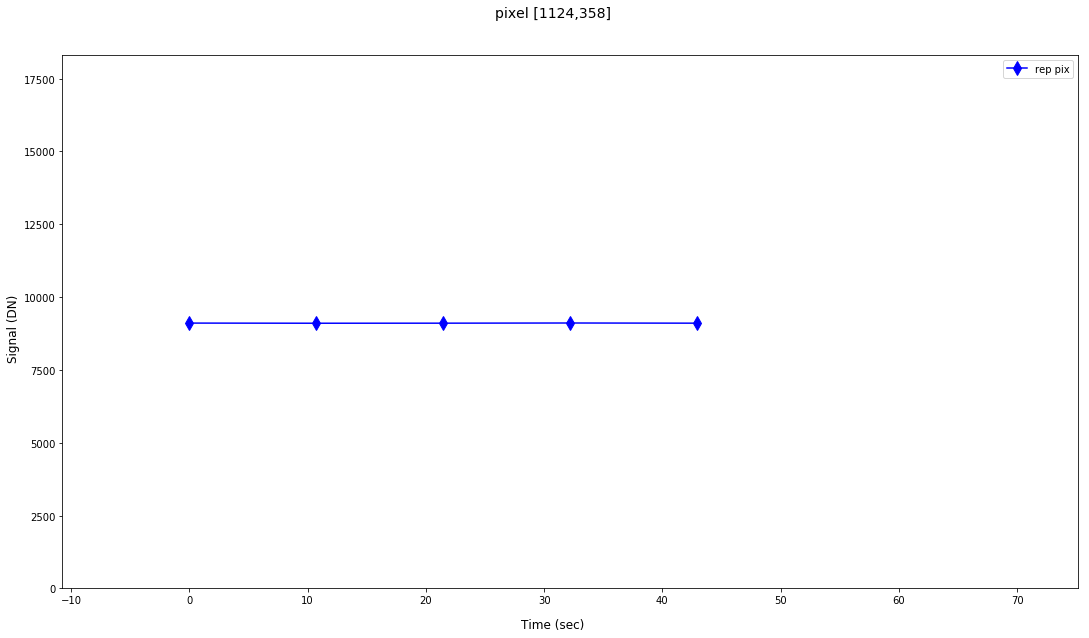

In [5]:
# plot pixels

f, ax = plt.subplots(1, 1, figsize=(15,8))
ax = plot_pixel(imageUncal, repx, repy,'rep pix',ax, 'blue',0,mean+10000, 0,ngroups+1, mode)
f.text(0.5, -0.02, 'Time (sec)', ha='center', fontsize=12)
f.text(0.5, 1.04, 'pixel [%s,%s]'% (str(repx),str(repy)), ha='center', fontsize=14)
f.text(-0.005, 0.5, 'Signal (DN)', va='center', rotation='vertical', fontsize=12)
f.tight_layout()

In [6]:
# check baseline values for data

print('\nFor representative pixel:')
print('IMAGE:',imageUncal[:,repy,repx])


For representative pixel:
('IMAGE:', array([ 9108.,  9103.,  9105.,  9111.,  9105.], dtype=float32))


## On to calibration

## A note about JWST python data models

The python method of running the pipeline doesn't involve the 
command line, so there are no file outputs unless you specifically tell it to 
write out a fits file. For example:

    calib_data = DQInitStep.call('yourfile.fits',output_file='yourfile_dq_init.fits') 

or alternately, using jwst.datamodels RampModel:

    fakeData = RampModel()
    fakeData.meta = RampModel("dark.fits").meta       # need to supply a file to get necessary headers
    filler = np.zeros((1,5,2048,2048))                # give it some fake data
    fakeData.data = filler
    fakeData.dq = filler[0,0,:,:]
    fakeData.groupdq = filler
    calib_data = DQInitStep.call(fakeData)

To override the default reference files, for example:

    sat = SaturationStep.call(file,override_saturation='dir/to/ref/reffile.fits')

To run the pipeline from the command line (in your pipeline environment):

    $ strun dq_init.cfg yourfile.fits

## Ramps-to-slopes pipeline: CALDETECTOR1 (calwebb_detector1)

The CALDETECTOR1 module is Level-1 of the pipeline that processes data taken with all instruments and modes.  The input to this stage is the raw non-destructively read ramps, and the output is uncalibrated slope images. With your calwebb_detector1.cfg file edited to only include the NIRCam steps, you can just run calwebb_detector1 to complete all detector-level calibrations at one time (rather than individually running each step).

** To run each step individually, skip to "First step: data quality array initialization" ** 

There are two ways to run this pipeline. If you want to override individual steps, use this method: 
    
    from jwst.pipeline import calwebb_detector1
    
    m = calwebb_detector1.Detector1Pipeline(config_file='calwebb_detector1.cfg')
    m.saturation.override_saturation = 'mysatfile.fits'
    m.superbias.override_superbias = 'mysuperbias.fits'
    m.refpix.odd_even_rows = False
    m.group_scale.skip = True
    m.ipc.skip = True
    m.dark_current.skip = True
    m.persistence.skip = True
    m.output_file = outfile
    m.run('myrawfile_uncal.fits')
    
Otherwise, see the method in the next cell.    

In [7]:
# get help with pipeline steps by typing: help(Detector1Pipeline)

# override the default cfg file with "config_file="
Detector1Pipeline.call(uncalFile,config_file='calwebb_detector1.cfg',output_file=fileBase+'_rate.fits')

# alternatively, you could run it via the command line way:
# strun calwebb_detector1.cfg uncalFile

2017-08-10 13:05:19,673 - stpipe.SloperPipeline - INFO - SloperPipeline instance created.
2017-08-10 13:05:19,679 - stpipe.SloperPipeline.group_scale - INFO - GroupScaleStep instance created.
2017-08-10 13:05:19,683 - stpipe.SloperPipeline.saturation - INFO - SaturationStep instance created.
2017-08-10 13:05:19,687 - stpipe.SloperPipeline.rscd - INFO - RSCD_Step instance created.
2017-08-10 13:05:19,691 - stpipe.SloperPipeline.ipc - INFO - IPCStep instance created.
2017-08-10 13:05:19,696 - stpipe.SloperPipeline.ramp_fit - INFO - RampFitStep instance created.
2017-08-10 13:05:19,700 - stpipe.SloperPipeline.linearity - INFO - LinearityStep instance created.
2017-08-10 13:05:19,705 - stpipe.SloperPipeline.jump - INFO - JumpStep instance created.
2017-08-10 13:05:19,710 - stpipe.SloperPipeline.refpix - INFO - RefPixStep instance created.
2017-08-10 13:05:19,714 - stpipe.SloperPipeline.lastframe - INFO - LastFrameStep instance created.
2017-08-10 13:05:19,718 - stpipe.SloperPipeline.dq_ini

In [8]:
# read and print the results of the caldetector1 pipeline

rate_image = slopes.data
rate_image_pixdq = slopes.dq
rate_image_err = slopes.err

print('\nFor representative pixel:')
print('IMAGE:',rate_image[repy,repx])
print('PIXELDQ:',rate_image[repy,repx])
print('ERR:',rate_image[repy,repx])


For representative pixel:
('IMAGE:', -0.13933605)
('PIXELDQ:', -0.13933605)
('ERR:', -0.13933605)


<module 'matplotlib.pyplot' from '/user/acanipe/miniconda3/envs/jwst71release/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

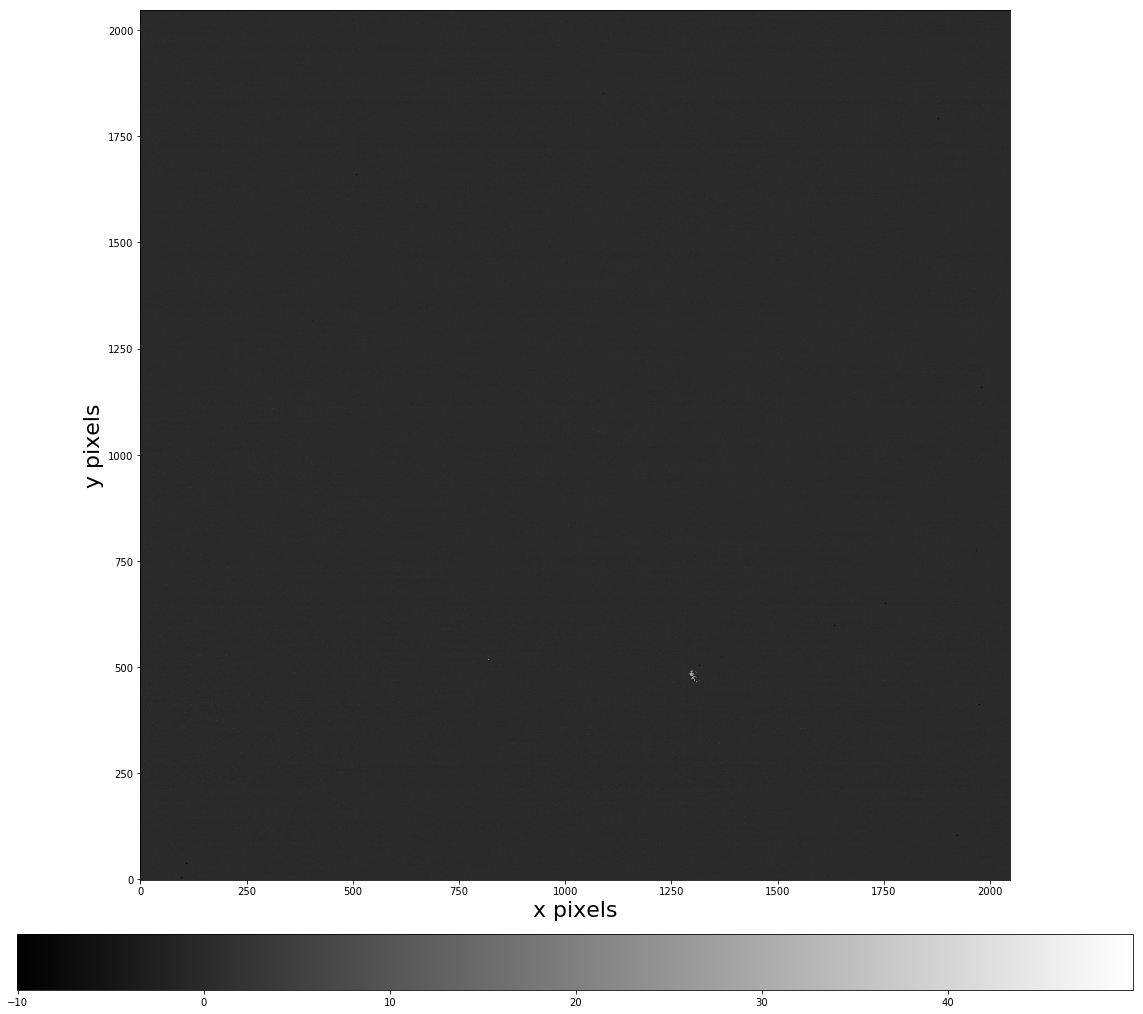

In [14]:
# display the rates
# vmin/vmax match ds9 scale limits or the limits of the data
# use sigma_clipped_stats to get mean for rate limits

rate_mean,rate_med,rate_std = sigma_clipped_stats(rate_image,sigma=3)
display_img(rate_image,rate_mean-10,rate_mean+50)

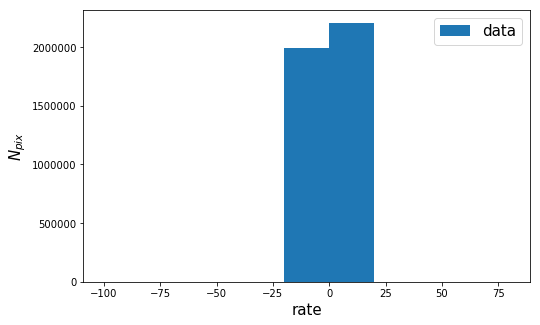

In [121]:
# make a histogram of the values in the first group
plt.figure(figsize=(8, 5))
bin_vals,bins,patches = plt.hist(np.ravel(rate_image),bins=np.arange(rate_mean-100,rate_mean+100,20),range=(rate_mean-100,rate_mean+100),label='data')
plt.xlabel('rate',fontsize=15)
plt.ylabel('$N_{pix}$',fontsize=15)
plt.legend(fontsize=15)

## Run pipeline steps individually

## First step: data quality array initialization

** Set the initial values of the Data Quality Flags for the pixels in the Science Data.**

**Description**: 
        Before any processing is started, pixels whose behavior is known to be significantly different from the majority are flagged with a value whose bits describe the nature of the discrepancy. Examples might be pixels known to be ‘hot’ (excessive dark current), low-sensitivity or whose calibratability is suspect. The Data Quality array will be propagated through the calibration process, augmenting the values with information discovered during calibration.

**Input Data**:
        Array containing science data

**Reference Information Needed**:
        Bad Pixel Mask Reference File,
        Gain information,
        Readout noise information

**Output Data**:
        Array containing science data (unchanged),
        Array containing Data Quality Bitmask,
        Array containing statistical errors



In [23]:
# get help with pipeline steps by typing: help(DQInitStep)

dq = DQInitStep.call(uncalFile)

2017-08-10 13:19:19,422 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2017-08-10 13:19:32,340 - stpipe.DQInitStep - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_nircam_mask_0026.fits'.
2017-08-10 13:19:32,597 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('NRCNRCA1-DARK-60012216201_1_481_SE_2016-01-02T02h34m28_uncal_sliced.fits',).
2017-08-10 13:19:36,287 - stpipe.DQInitStep - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_nircam_mask_0026.fits
2017-08-10 13:19:36,771 - stpipe.DQInitStep - WARNING - Keyword NON_Science does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-10 13:19:37,300 - stpipe.DQInitStep - WARNING - Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-10 13:19:37,303 - stpipe.DQInitStep - WARNING - Keyword WEIRD does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-10 13:19:47,517 - stpipe.DQInitStep - 

In [37]:
# prepare arrays to store the step by step results after calibrating for a final plot

listout_normpix = np.zeros((8,len(imageUncal[:,:,:])))
listout_normpix[0,:] = imageUncal[:,repy,repx]

grpdqout_normpix = np.zeros((8,len(imageUncal[:,:,:])))
grpdqout_normpix[0,:] = groupdq[:,repy,repx]

errout_normpix = np.zeros((8,len(imageUncal[:,:,:])))
errout_normpix[0,:] = err[:,repy,repx]

stepname = np.chararray((8,1),itemsize=9)
stepname[0,:] = 'RAW'  # this is the flag for the original data

In [40]:
# read and print the results of the dq_init pipeline step

image_dq = dq.data[0,:,:,:]
pixeldq_dq = dq.pixeldq
groupdq_dq = dq.groupdq
groupdq_dq = groupdq_dq[0,:,:,:]
err_dq = dq.err
err_dq = err_dq[0,:,:,:]

listout_normpix[1,:] = image_dq[:,repy,repx]
grpdqout_normpix[1,:] = groupdq_dq[:,repy,repx]
errout_normpix[1,:] = err_dq[:,repy,repx]
stepname[1,:] = 'DQ'  

print('\nFor representative pixel:')
print('IMAGE:',image_dq[:,repy,repx])
print('PIXELDQ:',pixeldq_dq[repy,repx])
print('GROUPDQ:',groupdq_dq[:,repy,repx])


For representative pixel:
('IMAGE:', array([ 9108.,  9103.,  9105.,  9111.,  9105.], dtype=float32))
('PIXELDQ:', 0)
('GROUPDQ:', array([0, 0, 0, 0, 0], dtype=uint8))


In [41]:
# check pixeldq by printing sorted, unique values in the array
print('\nPixeldq flags:\n')
print('Sim:',np.unique(pixeldq_dq))


# check to see if the pixeldq is getting properly updated according to the bad pixel mask
# you can figure out which mask was used by looking at the outputs from running DQInit
# table listing possible flags is here: 
# https://confluence.stsci.edu/display/JWSTPWG/JWST+Calibration+Reference+Files%3A+File+Formats+for+the+Build+6+Pipeline
bpm = '/grp/crds/cache/references/jwst/jwst_nircam_mask_0026.fits'
mask = fits.getdata(bpm,1)
badpix_value = 5 
badpix_coords = np.where(mask == 5)

print('\n\nCheck the bad pixel mask.\n')
print('Bad pixel mask value for pixel (',badpix_coords[0][0],badpix_coords[1][0],'):',mask[badpix_coords[0][0],badpix_coords[1][0]])
print('\nSo the pixeldq should be flagged for DEAD (1 for DO NOT USE and\n1024 for DEAD = 1025) if dq_init works correctly:\n')
print('pixeldq value for pixel (',badpix_coords[0][0],badpix_coords[1][0],'): after dq_init step:',pixeldq_dq[badpix_coords[0][0],badpix_coords[1][0]])


Pixeldq flags:

('Sim:', array([    0,     1,  1025,  2048,  2049, 16385, 81920], dtype=uint32))


Check the bad pixel mask.

('Bad pixel mask value for pixel (', 16, 2037, '):', 5)

So the pixeldq should be flagged for DEAD (1 for DO NOT USE and
1024 for DEAD = 1025) if dq_init works correctly:

('pixeldq value for pixel (', 16, 2037, '): after dq_init step:', 1025)


<module 'matplotlib.pyplot' from '/user/acanipe/miniconda3/envs/jwst71release/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

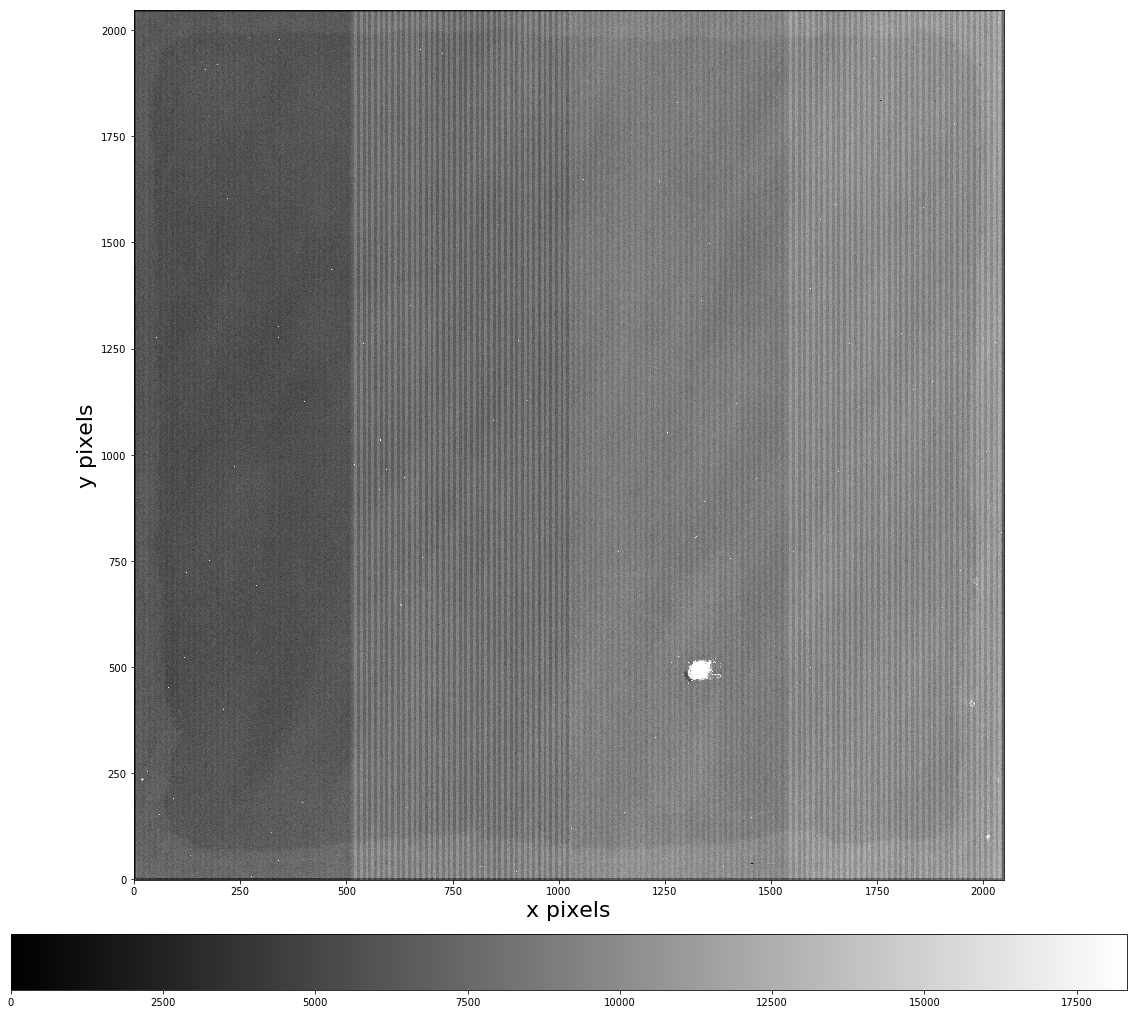

In [43]:
# look at image after dq_init step (should be unchanged!)

display_img(image_dq[0,:,:],0,mean+10000)


# # difference image
# diff_img_dq = image_dq[-1,:,:] - image_dq[0,:,:]
# display_img(diff_img_dq,0,mean+10000)


## Second step: saturation

**The saturation step flags saturated pixel values.**

**Description**: 
        It loops over all integrations within an exposure, examining them group-by-group, comparing the science exposure values with defined saturation thresholds for each pixel. When it finds a pixel value in a given group that is above the threshold, it sets the SATURATED flag in the corresponding location of the GROUPDQ array in the science exposure.

**Input Data**:
        Array containing science data

**Reference Information Needed**:
        Saturation reference file

**Output Data**:
        Array containing science data,
        Array containing Data Quality Bitmask,
        Array containing statistical errors
        
For pixels having a saturation threshold set to NaN in the reference file, those thresholds will be replaced by 100000, a very high value that exceeds any possible science data pixel value. This ensures that these pixels will not be flagged by this step as saturated. The associated groupdq values will be flagged as NO_SAT_CHECK in the step output. Similarly, for pixels flagged as NO_SAT_CHECK in the reference file, they will be added to the dq mask, and have their saturation values set to be so high they will not be flagged as saturated.

In [44]:
# get help with pipeline steps by typing: help(SaturationStep)

sat = SaturationStep.call(dq)

2017-08-10 13:29:03,211 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2017-08-10 13:29:06,406 - stpipe.SaturationStep - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_nircam_saturation_0064.fits'.
2017-08-10 13:29:06,685 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<jwst.datamodels.ramp.RampModel object at 0x7ff298ec7090>,).
2017-08-10 13:29:09,304 - stpipe.SaturationStep - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_nircam_saturation_0064.fits
2017-08-10 13:29:09,714 - stpipe.SaturationStep - WARNING - Keyword NO_SATURATION does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-10 13:29:09,715 - stpipe.SaturationStep - WARNING - Keyword FEW_SAMPLES does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-10 13:29:09,716 - stpipe.SaturationStep - WARNING - Keyword AD_SATURATION does not correspond to an existing DQ mnemonic, so wil

In [45]:
# read and print the results of the saturation pipeline step


print('\n\nSaturated pixels should now be flagged with 2 in the GROUPDQ array for groups with \nvalues exceeding the saturation level in the reference file.')


image_sat = sat.data
image_sat = image_sat[0,:,:,:]
pixeldq_sat = sat.pixeldq
groupdq_sat = sat.groupdq
groupdq_sat = groupdq_sat[0,:,:,:]
err_sat = sat.err
err_sat = err_sat[0,:,:,:]

listout_normpix[2,:] = image_sat[:,repy,repx]
grpdqout_normpix[2,:] = groupdq_sat[:,repy,repx]
errout_normpix[2,:] = err_sat[:,repy,repx]
stepname[2,:] = 'SAT'

print('\nFor representative pixel:')
print('IMAGE:',image_sat[:,repy,repx])
print('PIXELDQ:',pixeldq_sat[repy,repx])
print('GROUPDQ:',groupdq_sat[:,repy,repx])



Saturated pixels should now be flagged with 2 in the GROUPDQ array for groups with 
values exceeding the saturation level in the reference file.

For representative pixel:
('IMAGE:', array([ 9108.,  9103.,  9105.,  9111.,  9105.], dtype=float32))
('PIXELDQ:', 0)
('GROUPDQ:', array([0, 0, 0, 0, 0], dtype=uint8))


In [46]:
# check pixeldq by printing sorted, unique values in the array

print('\nPixeldq flags in both arrays:\n')
print('Sim:',np.unique(pixeldq_sat))


Pixeldq flags in both arrays:

('Sim:', array([      0,       1,    1025,    2048,    2049,   16385,   81920,
       2097152, 2097153, 2098177, 2099200, 2099201, 2113537, 2179072], dtype=uint32))


<module 'matplotlib.pyplot' from '/user/acanipe/miniconda3/envs/jwst71release/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

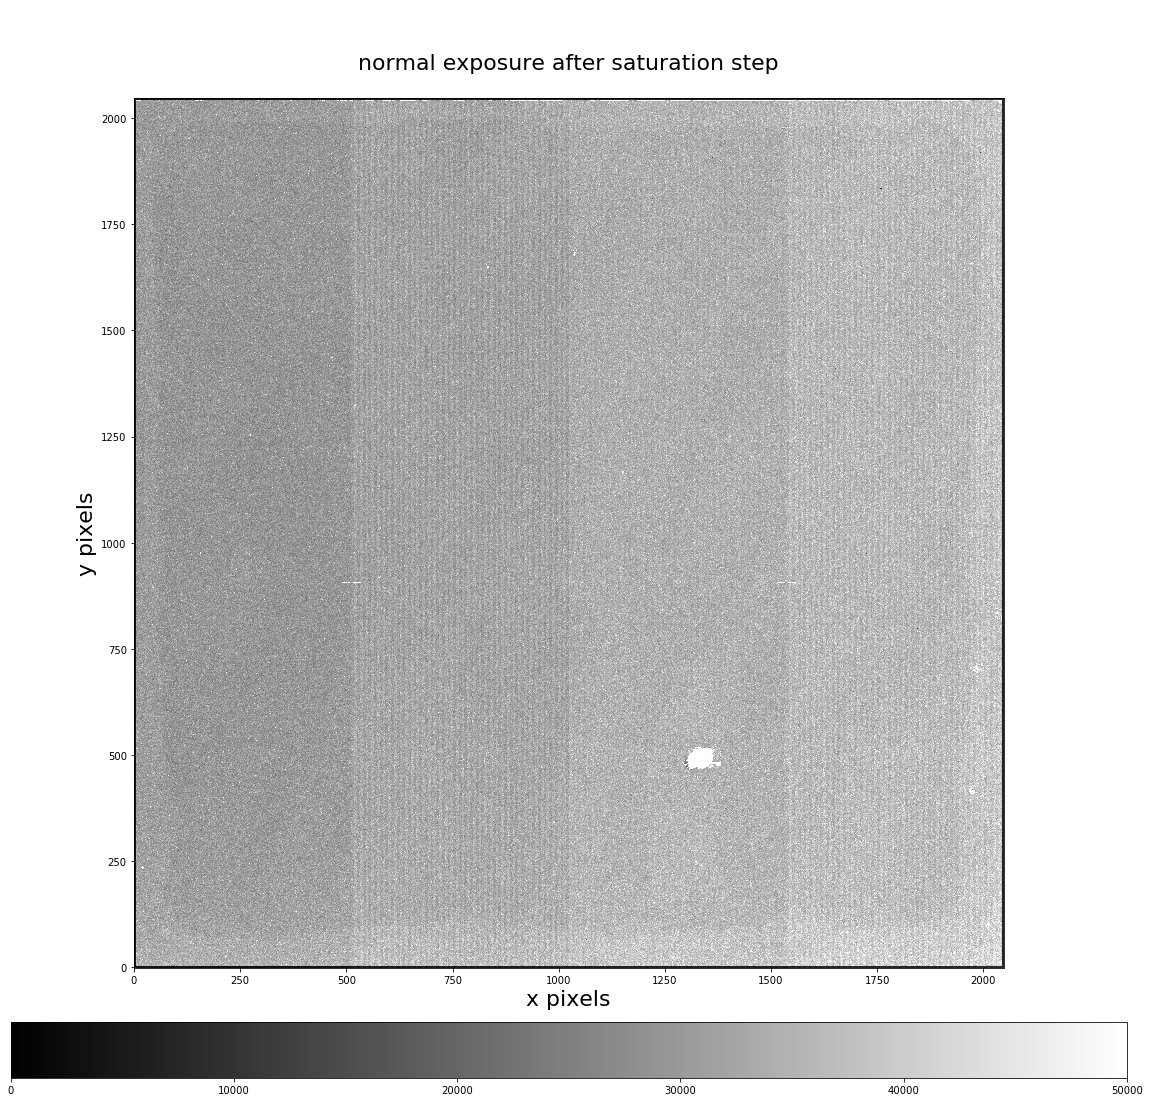

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [23]:
# look at images after saturation step (should be unchanged!)

# simulated image
display_img(image_sat[0,:,:],0,mean+10000)

# # difference image
# diff_img_sat = image_sat[-1,:,:] - image_sat[0,:,:]
# display_img(diff_img_sat,0,mean+10000)

## Third step: superbias subtraction

**The superbias subtraction step removes the fixed detector bias from a science data set by subtracting a superbias reference image.**

**Description**: 
        The 2-D superbias reference image is subtracted from every group in every integration of the input science ramp data. Any NaN’s that might be present in the superbias image are set to a value of zero before being subtracted from the science data, such that those pixels effectively receive no correction.
        
**Input Data**:
        Array containing science data

**Reference Information Needed**:
        Superbias reference file

**Output Data**:
        Array containing science data,
        Superbias reference file DQ array combined with science exposure PIXELDQ array,
        ERR arrays are unchanged.
        

In [47]:
# get help with pipeline steps by typing: help(SuperBiasStep)

sup = SuperBiasStep.call(sat)

2017-08-10 13:30:53,929 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2017-08-10 13:30:56,909 - stpipe.SuperBiasStep - INFO - Prefetch for SUPERBIAS reference file is '/grp/crds/cache/references/jwst/jwst_nircam_superbias_0026.fits'.
2017-08-10 13:30:57,186 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args (<jwst.datamodels.ramp.RampModel object at 0x7ff29a5201d0>,).
2017-08-10 13:30:59,806 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file /grp/crds/cache/references/jwst/jwst_nircam_superbias_0026.fits
2017-08-10 13:31:00,544 - stpipe.SuperBiasStep - WARNING - Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-10 13:31:02,136 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep done


In [48]:
# read and print the results of the superbias pipeline step

image_sup = sup.data
image_sup = image_sup[0,:,:,:]
pixeldq_sup = sup.pixeldq
groupdq_sup = sup.groupdq
groupdq_sup = groupdq_sup[0,:,:,:]
err_sup = sup.err
err_sup = err_sup[0,:,:,:]


# get superbias from reference file used by the pipeline
superbiases = fits.getdata('/grp/crds/cache/references/jwst/jwst_nircam_superbias_0026.fits',1)
print('\nFor representative pixel, the superbias step should have subtracted: %0.3f' % superbiases[repy,repx])
print('Amount subtracted for saturated pixel:',image_sat[0,repy,repx]-image_sup[0,repy,repx])

listout_normpix[3,:] = image_sup[:,repy,repx]
grpdqout_normpix[3,:] = groupdq_sup[:,repy,repx]
errout_normpix[3,:] = err_sup[:,repy,repx]
stepname[3,:] =  'SUP'

print('\nFor representative pixel:')
print('IMAGE:',image_sup[:,repy,repx])
print('PIXELDQ:',pixeldq_sup[repy,repx])
print('GROUPDQ:',groupdq_sup[:,repy,repx])
print('ERR:',err_sup[:,repy,repx])


For representative pixel, the superbias step should have subtracted: 3142.702
('Amount subtracted for saturated pixel:', 3142.7017)

For representative pixel:
('IMAGE:', array([ 5965.29833984,  5960.29833984,  5962.29833984,  5968.29833984,
        5962.29833984], dtype=float32))
('PIXELDQ:', 0)
('GROUPDQ:', array([0, 0, 0, 0, 0], dtype=uint8))
('ERR:', array([ 0.,  0.,  0.,  0.,  0.], dtype=float32))


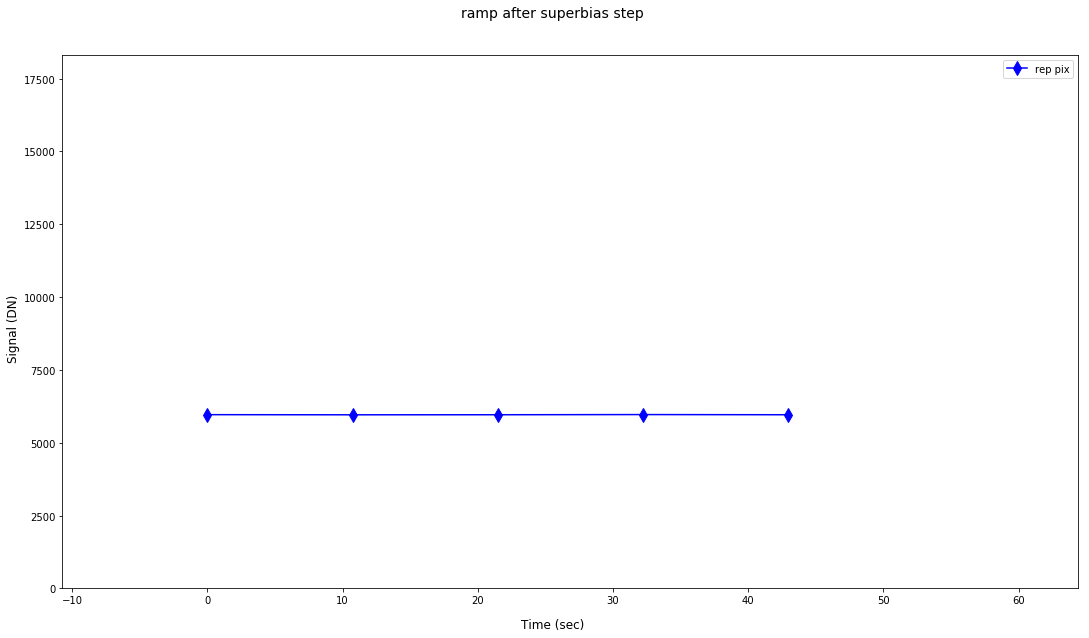

In [49]:
# plot some ramps after superbias 

# simulated data pixels
f, ax = plt.subplots(1, 1, figsize=(15,8))
ax = plot_pixel(image_sup, repx, repy, 'rep pix',ax, 'blue',0,mean+10000, 0, ngroups, mode)

f.text(0.5, -0.02, 'Time (sec)', ha='center', fontsize=12)
f.text(0.5, 1.04, 'ramp after superbias step', ha='center', fontsize=14)
f.text(-0.005, 0.5, 'Signal (DN)', va='center', rotation='vertical', fontsize=12)
f.tight_layout()

<module 'matplotlib.pyplot' from '/user/acanipe/miniconda3/envs/jwst71release/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

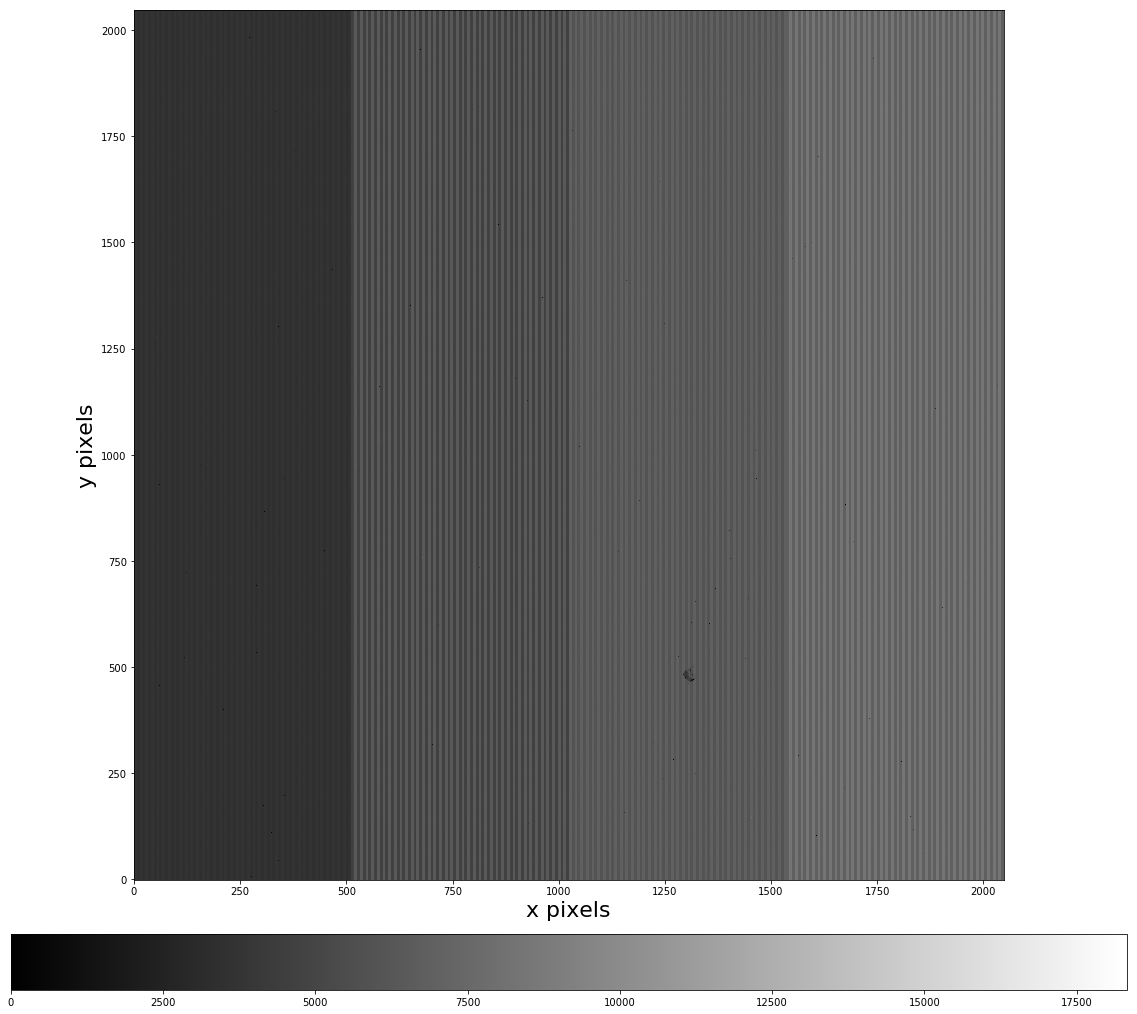

In [50]:
# look at images after superbias step

# simulated image
display_img(image_sup[0,:,:],0,mean+10000)


# # difference image
# diff_img_sup = image_sup[-1,:,:] - image_sup[0,:,:]
# display_img(diff_img_sup,0,mean+10000)

## Fourth step: bias drift correction

**The bias drift step corrects for amplifier drifs using the reference pixels.**

**Description**:        
        Readout electronics impose a signal on top of the detected photons. Amplifiers add a constant value to each pixel that is different between amplifiers and groups. In addition, superposed on this signal is a variation that is mainly with row number that seems to apply to all amplifiers within a group. This step corrects for these drifts by using the reference pixels, a 4-pixel wide strip around the edge of the detectors that are completely insensitive to light.

**Input Data**: Array containing science data with a data quality extension.

**Reference Information Needed**: No reference file used for instruments other than NIRSpec.

**Output Data**: Array containing science data.


In [52]:
# get help with pipeline steps by typing: help(RefPixStep)

# ** make sure refpix.cfg has odd_even_rows = False **

ref = RefPixStep.call(sup, config_file='refpix.cfg')

2017-08-10 13:32:39,983 - stpipe.refpix - INFO - RefPixStep instance created.
2017-08-10 13:32:42,887 - stpipe.refpix - INFO - Prefetch for REFPIX reference file is 'N/A'.
2017-08-10 13:32:43,083 - stpipe.refpix - INFO - Step refpix running with args (<jwst.datamodels.ramp.RampModel object at 0x7ff29a336210>,).
2017-08-10 13:32:44,037 - stpipe.refpix - INFO - use_side_ref_pixels = True
2017-08-10 13:32:44,038 - stpipe.refpix - INFO - odd_even_columns = True
2017-08-10 13:32:44,039 - stpipe.refpix - INFO - side_smoothing_length = 11
2017-08-10 13:32:44,040 - stpipe.refpix - INFO - side_gain = 1.000000
2017-08-10 13:32:44,040 - stpipe.refpix - INFO - odd_even_rows = False
2017-08-10 13:32:46,930 - stpipe.refpix - INFO - Step refpix done


In [53]:
# read and print the results of the bias drift correction pipeline step

image_ref = ref.data[0,:,:,:]
pixeldq_ref = ref.pixeldq
groupdq_ref = ref.groupdq
groupdq_ref = groupdq_ref[0,:,:,:]
err_ref = ref.err
err_ref = err_ref[0,:,:,:]

listout_normpix[4,:] = image_ref[:,repy,repx]
grpdqout_normpix[4,:] = groupdq_ref[:,repy,repx]
errout_normpix[4,:] = err_ref[:,repy,repx]
stepname[4,:] =  'REFPIX'  

print('\nFor representative pixel:')
print('IMAGE:',image_ref[:,repy,repx])
print('PIXELDQ:',pixeldq_ref[repy,repx])
print('GROUPDQ:',groupdq_ref[:,repy,repx])
print('ERR:',err_ref[:,repy,repx])


For representative pixel:
('IMAGE:', array([-20.51220703, -20.25500488, -28.67736816, -34.36151123, -21.7243042 ], dtype=float32))
('PIXELDQ:', 0)
('GROUPDQ:', array([0, 0, 0, 0, 0], dtype=uint8))
('ERR:', array([ 0.,  0.,  0.,  0.,  0.], dtype=float32))


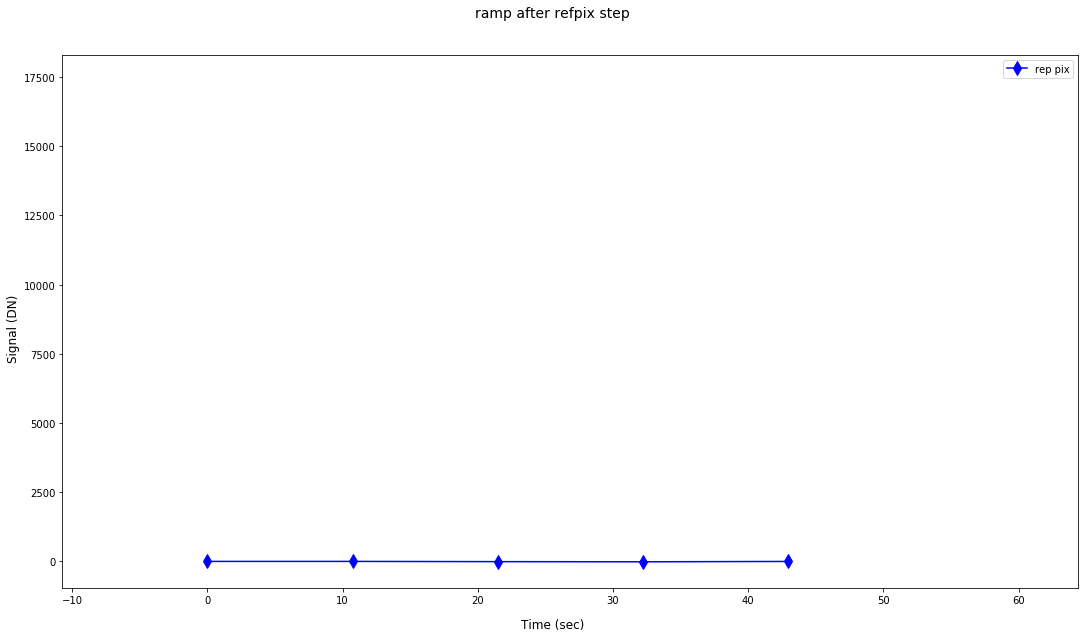

In [56]:
# plot some ramps after refpix 

# simulated data pixels
f, ax = plt.subplots(1, 1, figsize=(15,8))
ax = plot_pixel(image_ref, repx, repy,'rep pix',ax, 'blue',-1000,mean+10000, 0, ngroups, mode)

f.text(0.5, -0.02, 'Time (sec)', ha='center', fontsize=12)
f.text(0.5, 1.04, 'ramp after refpix step', ha='center', fontsize=14)
f.text(-0.005, 0.5, 'Signal (DN)', va='center', rotation='vertical', fontsize=12)
f.tight_layout()

<module 'matplotlib.pyplot' from '/user/acanipe/miniconda3/envs/jwst71release/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

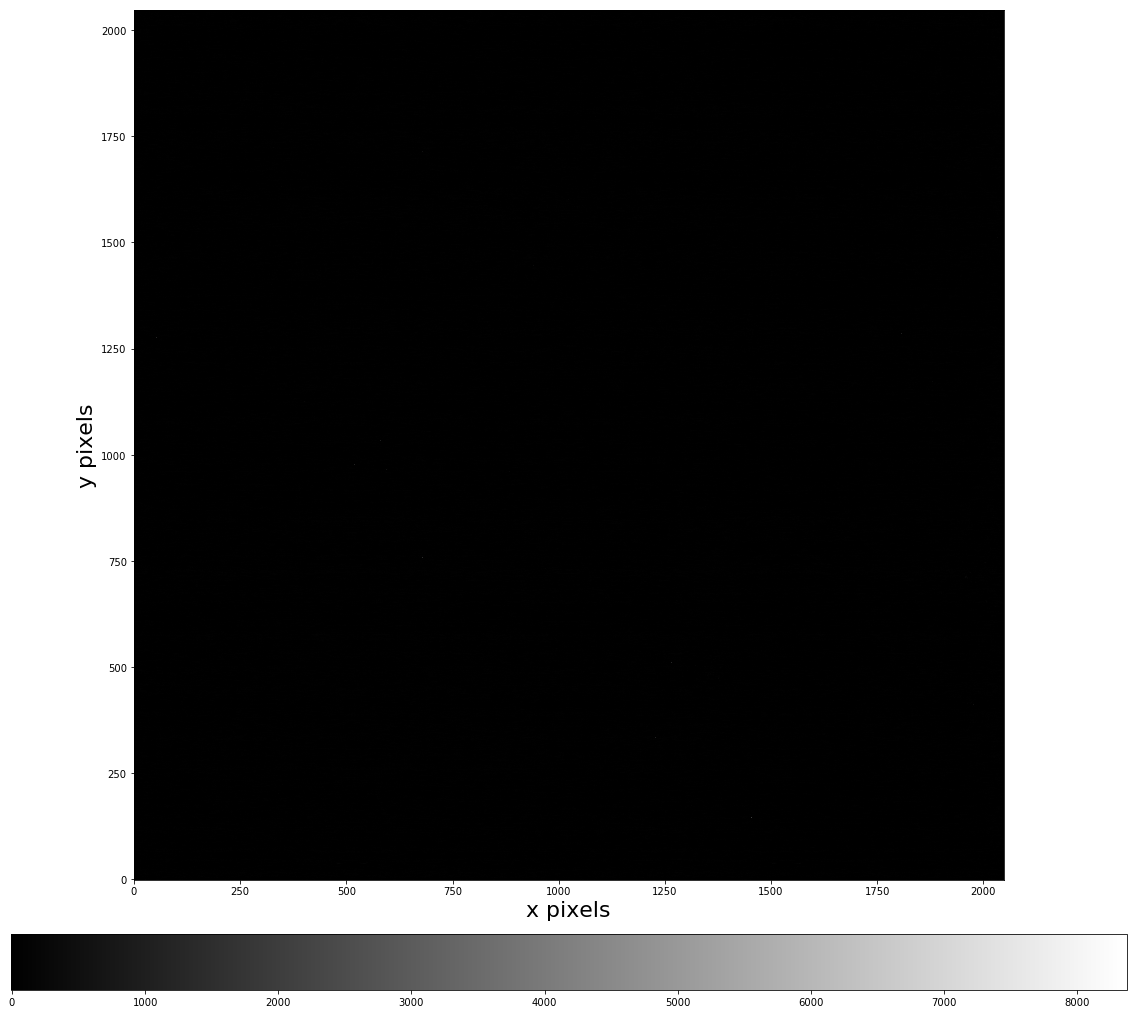

In [59]:
# look at images after refpix step 

# simulated image
display_img(image_ref[0,:,:],-10,mean+50)


# # difference image
# diff_img_ref = image_ref[-1,:,:] - image_ref[0,:,:]
# display_img(diff_img_ref,0,mean+10000)


## Fifth step: non-linearity correction

**The linearity step corrects for IR detector non-linear response.**

**Description**:        
       The linearity step applies the “classic” linearity correction adapted from the HST WFC3/IR linearity correction routine, correcting science data values for detector non-linearity. The correction is applied pixel-by-pixel, group-by-group, integration-by-integration within a science exposure. The correction is represented by an nth-order polynomial for each pixel in the detector, with n+1 arrays of coefficients read from the linearity reference file. The algorithm for correcting the observed pixel value in each group of an integration is currently of the form Fc=c0+c1*F+c2*F^2+c3*F^3... where is the observed counts (in DN), cn are the polynomial coefficients, and F^c is the corrected counts. There is no limit to the order of the polynomial correction; all coefficients contained in the reference file will be applied.

**Input Data**: Array containing science data with a data quality extension.

**Reference Information Needed**: Linearity reference files are FITS format with 2 IMAGE extensions and 1 BINTABLE extension.  The primary data array is assumed to be empty. The 2 IMAGE extensions have the following characteristics:
    
        EXTNAME     NAXIS     Dimensions                  Data type     
        COEFFS      3         ncols x nrows x ncoeffs     float
        DQ          2         ncols x nrows               integer

Each plane of the COEFFS data cube contains the pixel-by-pixel coefficients for the associated order of the polynomial. There can be any number of planes to accomodate a polynomial of any order. The BINTABLE extension uses EXTNAME=DQ_DEF
and contains the bit assignments of the conditions flagged in the DQ array.

**Output Data**: 
        Array containing science data. Pixels having at least one correction coefficient equal to NaN (not a number), or are flagged with “Linearity Correction not determined for pixel” (NO_LIN_CORR) in the PIXELDQ array will not have the linearity correction applied. Pixel values flagged as saturated in the GROUPDQ array for a given group will not have the linearity correction applied. All non-saturated groups for such a pixel will have the correction applied. The ERR array of the input science exposure is not modified. The values from the linearity reference file DQ array are propagated into the PIXELDQ array of the input science exposure using a bitwise OR operation.


In [60]:
# get help with pipeline steps by typing: help(LinearityStep)

lin = LinearityStep.call(ref)

2017-08-10 13:34:48,418 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2017-08-10 13:34:51,385 - stpipe.LinearityStep - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_nircam_linearity_0056.fits'.
2017-08-10 13:34:51,559 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<jwst.datamodels.ramp.RampModel object at 0x7ff29a639c90>,).
2017-08-10 13:34:53,924 - stpipe.LinearityStep - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_nircam_linearity_0056.fits
2017-08-10 13:34:54,546 - stpipe.LinearityStep - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-10 13:34:54,547 - stpipe.LinearityStep - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
2017-08-10 13:34:54,548 - stpipe.LinearityStep - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be i

In [61]:
# read and print the results of the linearity pipeline step

image_lin = lin.data[0,:,:,:]
pixeldq_lin = lin.pixeldq
groupdq_lin = lin.groupdq
groupdq_lin = groupdq_lin[0,:,:,:]
err_lin = lin.err
err_lin = err_lin[0,:,:,:]

listout_normpix[5,:] = image_lin[:,repy,repx]
grpdqout_normpix[5,:] = groupdq_lin[:,repy,repx]
errout_normpix[5,:] = err_lin[:,repy,repx]
stepname[5,:] =  'LINEARITY' 

print('\nFor representative pixel:')
print('IMAGE:',image_lin[:,repy,repx])
print('PIXELDQ:',pixeldq_lin[repy,repx])
print('GROUPDQ:',groupdq_lin[:,repy,repx])
print('ERR:',err_lin[:,repy,repx])


For representative pixel:
('IMAGE:', array([-20.51187134, -20.25467682, -28.67671394, -34.36057281, -21.72392654], dtype=float32))
('PIXELDQ:', 0)
('GROUPDQ:', array([0, 0, 0, 0, 0], dtype=uint8))
('ERR:', array([ 0.,  0.,  0.,  0.,  0.], dtype=float32))


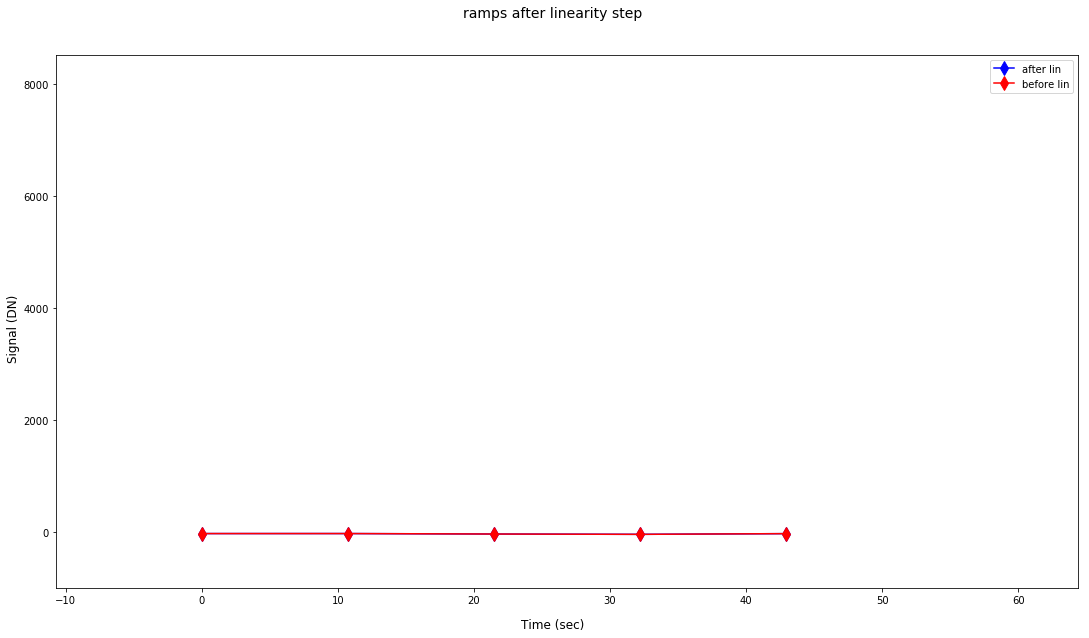

In [66]:
# plot some ramps after linearity 

# simulated data pixels
f, ax  = plt.subplots(1, 1, figsize=(15,8))
ax = plot_pixel(image_lin, repx, repy,'after lin',ax, 'blue',-1000,mean+200, 0, ngroups,mode)
ax = plot_pixel(image_ref, repx, repy, 'before lin',ax, 'red',-1000,mean+200, 0, ngroups,mode)

f.text(0.5, -0.02, 'Time (sec)', ha='center', fontsize=12)
f.text(0.5, 1.04, 'ramps after linearity step', ha='center', fontsize=14)
f.text(-0.005, 0.5, 'Signal (DN)', va='center', rotation='vertical', fontsize=12)
f.tight_layout()

<module 'matplotlib.pyplot' from '/user/acanipe/miniconda3/envs/jwst71release/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

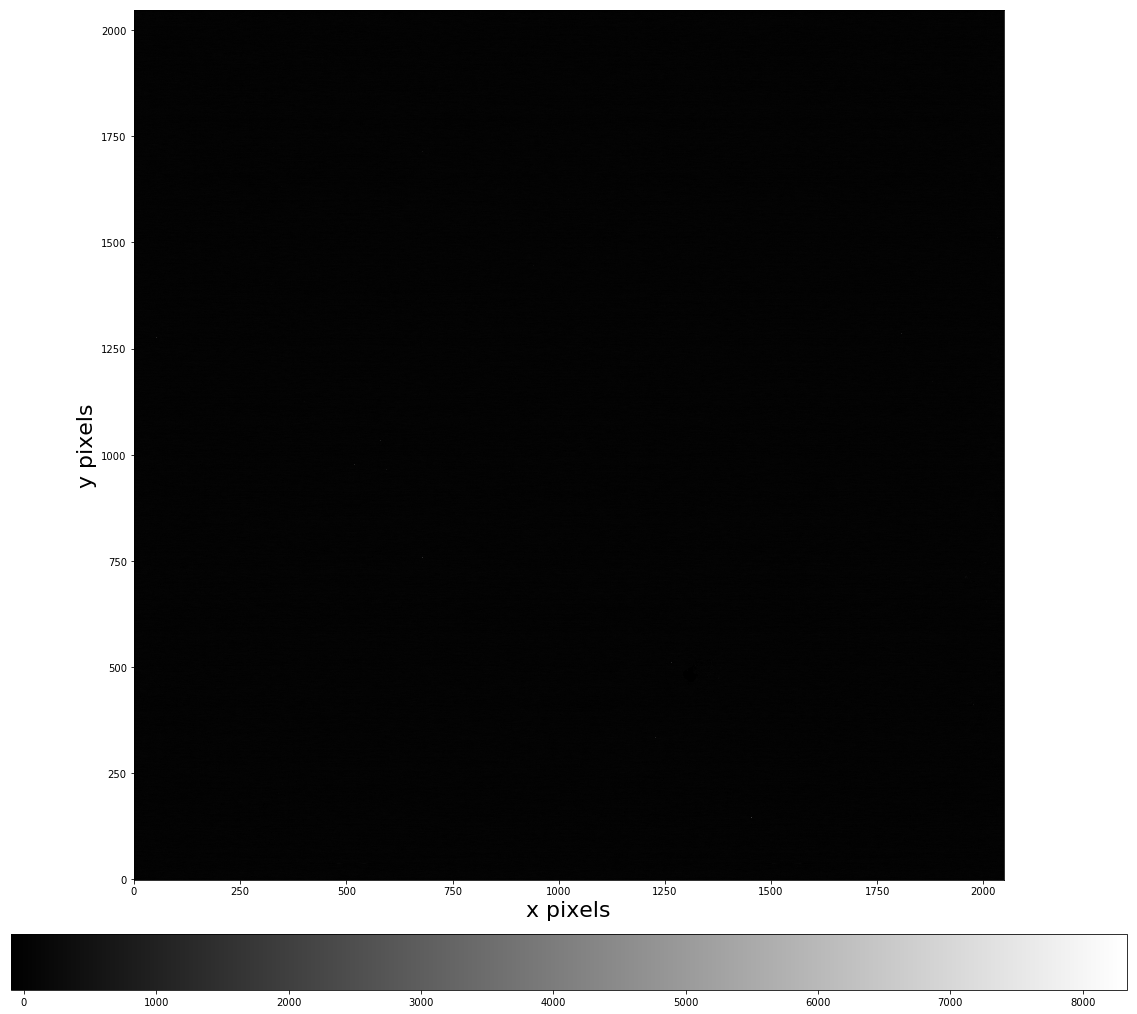

In [68]:
# look at images after linearity step 

display_img(image_lin[0,:,:],-100,mean+10)


# # difference image
# diff_img_lin = image_lin[-1,:,:] - image_lin[0,:,:]
# display_img(diff_img_lin,0,mean+20000)

## Sixth step: jump detection

**The jump step detects jumps in an exposure.**

**Description**:        
       This routine detects jumps in an exposure by looking for outliers in the up-the-ramp signal for each pixel in each integration within an input exposure. The  current  implementation  uses  a  combination  of  the  two-point  difference  and  y-intercept  methods  described  in Anderson and Gordon, PASP 132, 1237 (2011).  These methods are applied to the data in two passes.  The two-point difference method, which is computationally cheap, is applied in a first pass to all pixels in each integration. The y-intercept method, which is computationally expensive, is applied in a second pass to only those pixels that have signal levels in the read noise regime, where it provides somewhat better results than the two-point difference method.  The y-intercept method is only applied if the jump step parameter ‘do_yintercept’ is set to True (default is False).

**Input Data**: Array containing science data.

**Step Arguments**: The Jump step has three optional arguments that can be set by the user:
        
        --rejection_threshold: A floating-point value that sets the sigma threshold for jump detection.
        
        --do_yintercept: A True/False value that indicates whether to apply the y-intercept method.
        
        --yint_threshold: A floating-point value that sets the signal threshold for applying the y-intercept method to individual pixels.
        
**Reference Information Needed**: Gain and Readnoise. The gain values are used to temporarily convert the pixel
values from units of DN to electrons. The read noise values are used as part of the noise estimate for each pixel. Both
are necessary for proper computation of noise estimates.        

**Output Data**: 
        Array containing science data. GROUPDQ array of the data is updated to reflect the location of each jump that was found. The SCI, ERR, and PIXELDQ arrays of the input data are not modified.


In [70]:
# get help with pipeline steps by typing: help(JumpStep)

# you can change the rejection threshold with "rejection_threshold"
# jump = JumpStep.call(lin,rejection_threshold=10)
jump = JumpStep.call(lin)

2017-08-10 13:39:17,274 - stpipe.JumpStep - INFO - JumpStep instance created.
2017-08-10 13:39:20,157 - stpipe.JumpStep - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_nircam_gain_0028.fits'.
2017-08-10 13:39:20,160 - stpipe.JumpStep - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_nircam_readnoise_0025.fits'.
2017-08-10 13:39:20,389 - stpipe.JumpStep - INFO - Step JumpStep running with args (<jwst.datamodels.ramp.RampModel object at 0x7ff2994684d0>,).
2017-08-10 13:39:21,337 - stpipe.JumpStep - INFO - CR rejection threshold = 4 sigma
2017-08-10 13:39:22,845 - stpipe.JumpStep - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_nircam_gain_0028.fits
2017-08-10 13:39:24,515 - stpipe.JumpStep - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_nircam_readnoise_0025.fits
2017-08-10 13:39:26,323 - stpipe.JumpStep - INFO - Executing two-point difference method
2017-08-10 1

In [71]:
# read and print the results of the jump pipeline step

print('\n\nCR jumps should now be flagged with 4 in the GROUPDQ array for groups with \na cosmic ray hit.\n')

image_jump = jump.data[0,:,:,:]
pixeldq_jump = jump.pixeldq
groupdq_jump = jump.groupdq
groupdq_jump = groupdq_jump[0,:,:,:]
err_jump = jump.err
err_jump = err_jump[0,:,:,:]

listout_normpix[6,:] = image_jump[:,repy,repx]
grpdqout_normpix[6,:] = groupdq_jump[:,repy,repx]
errout_normpix[6,:] = err_jump[:,repy,repx]
stepname[6,:] =  'JUMP'

print('\nFor representative pixel:')
print('IMAGE:',image_jump[:,repy,repx])
print('PIXELDQ:',pixeldq_jump[repy,repx])
print('GROUPDQ:',groupdq_jump[:,repy,repx])
print('ERR:',err_jump[:,repy,repx])



CR jumps should now be flagged with 4 in the GROUPDQ array for groups with 
a cosmic ray hit.


For representative pixel:
('IMAGE:', array([-20.51187134, -20.25467682, -28.67671394, -34.36057281, -21.72392654], dtype=float32))
('PIXELDQ:', 0)
('GROUPDQ:', array([0, 0, 0, 0, 0], dtype=uint8))
('ERR:', array([ 0.,  0.,  0.,  0.,  0.], dtype=float32))


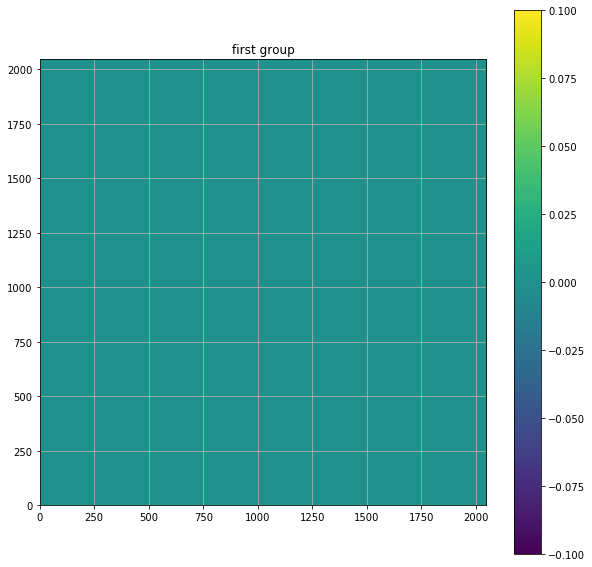

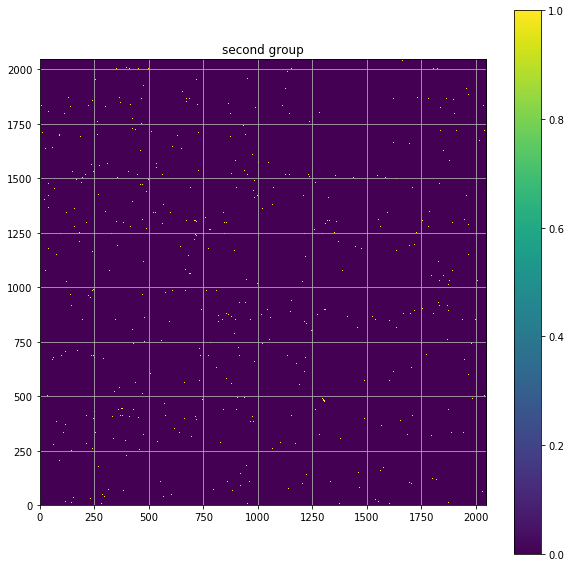

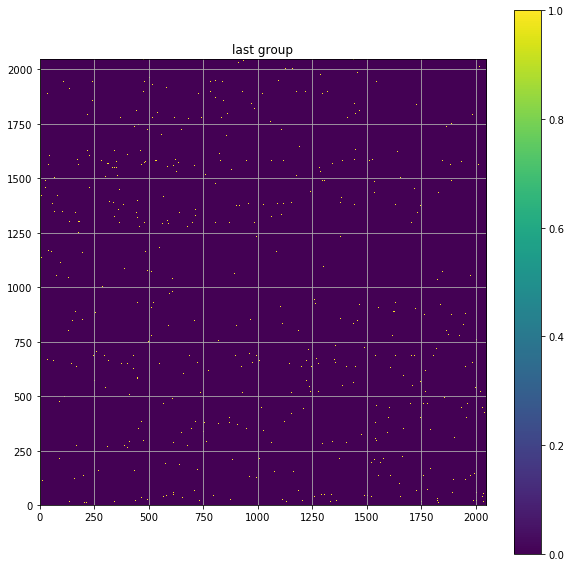

In [72]:
# check cosmic ray flags in each group

first_groupdq = groupdq_jump[0,:,:]
second_groupdq = groupdq_jump[1,:,:]
last_groupdq = groupdq_jump[-1,:,:]
ind1 = first_groupdq == 4
ind2 = second_groupdq == 4
ind3 = last_groupdq == 4
all_ind = [ind1,ind2,ind3]
all_ind_gp = ['first group','second group', 'last group']


for inds,name in zip(all_ind,all_ind_gp):
    plt.figure(figsize=(10,10))
    plt.title(name)
    plt.imshow(inds,cmap='viridis',origin='lower',interpolation='nearest')
    plt.grid(True)
    plt.colorbar()
    plt.show()

## Seventh step: ramp fit

**This step determines the mean count rate for each pixel by performing a linear fit to the data (each pixel) in the input (jump) file.**

**Description**:        
       This step determines the mean count rate for each pixel by performing a linear fit to the data in the input (jump) file. The fit is performed independently for each pixel. The fit may be done using “ordinary least squares” or “generalized least squares.”  The primary output file (RampFit, giving the slope at each pixel) is the same for both algorithms, and the per-integration output file is also comparable, but the optional output file is significantly different for generalized least squares. Ordinary least squares is the default. When using ordinary least squares, the count rate for each pixel is determined by a linear fit to the cosmic-ray-free ramp intervals for each pixel. CR-free intervals are derived using the 4-D GROUPDQ array of the input data set, under the assumption that the jump step will have already flagged CR’s. Ramp intervals are also terminated where saturation flags are found.  Ramp intervals that are noiseless, or have no signal, or contain only 2 reads will initially have fits with variance = 0, preventing their slopes from contributing to the weighted slopes.  In these cases, the variance will be recalculated as the poisson noise of the ramp added in quadrature to the pixel-specific read noise, ensuring that all variance values are positive.  If the input dataset has only a single group in each integration, the count rate for all unsaturated pixels in that integration will be calculated to be the value of the science data in that group divided by the exposure time. If any input dataset contains ramps saturated in their second read, the count rates for those pixels in that integration will be calculated to be the value of the science data in that group divided by the exposure time. After computing the slopes for all intervals for a given pixel, the final slope is determined as a weighted average from all intervals and is written to a file as the primary output product. If the input exposure contains more than one integration, the resulting slope images from each integration are stored as a data cube in a second output data product. Each plane of the 3-D SCI, ERR, and DQ arrays in this product is the result for a given integration.

**Input Data**: Array containing science data.

**Step Arguments**: The Jump step has three optional arguments that can be set by the user:
        
        --save_opt: A True/False value that specifies whether to write optional output information.
        
        --opt_name: A string that can be used to override the default name for the optional output information.
        
        --int_name: A string that can be used to override the default name for the integration-by-integration slopes, for the case that the input file contains more than one integration
        
        --algorithm: A string that can be set to GLS to mean that generalized least squares should be used for the fit. The default value is OLS, which means to use ordinary least squares.
        
        --weighting:  A string that can be set to OPTIMAL to perform the fitting with the weighting scheme used by Fixsen et al, PASP,112, 1350. This option is only available when using ordinary least squares. The default is UNWTD, which means a uniform weighting scheme will be used.
        
**Reference Information Needed**: Read noise reference files are FITS format files having a single IMAGE extension, labeled SCI, which contains a 2-D floating-point array of read noise values per pixel.  The units of the read noise should be electrons and should be the CDS (Correlated Double Sampling) read noise, i.e.  the effective noise between any pair of non-destructive detector reads. The gain reference file is a FITS file with a single IMAGE extension, labeled SCI, which contains a 2-D floating-point array of gain values (in e/DN) per pixel.      

**Output Data**: 
       Slope image in units of counts (DN) or counts per second. If NINTS > 1, it will also put out an integration-by-integration slope image. The 4-D GROUPDQ from all integrations is compressed into 2-D, which is then merged (using a bitwise OR) with the input 2-D PIXELDQ to create the output PIXELDQ. By default, the name of this output product is based on the name of the input file. Note -- when running this in Python, the output is a tuple of [slope image, integration slope image]. 

In [2]:
# get help with pipeline steps by typing: help(RampFitStep)

# for the ramp-fit step, there is an optional output file that gives you 
# slope v. group, y-intercept, and pedestal values
# you have to save that separately

# give the name of the outputs. 
# ** NOTE **: an extension of "_0.fits" gets added for the slope image
# and an extension of "_1.fits" gets added for the integration dependent slope image
regular_output = fileBase+'_rate.fits'
optional_output = fileBase+'_opt.fits'

# save_opt=True and opt_name give you the optional outputs
ramp, rampints = RampFitStep.call(jump,output_file=regular_output,save_opt=True,opt_name=optional_output)

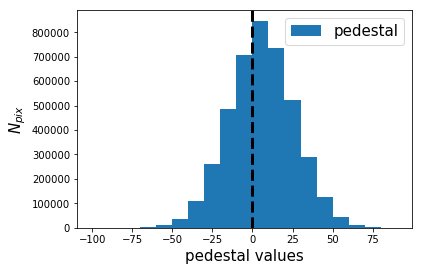

In [75]:
# look at pedestal values
ped = fits.getdata(optional_output,5)[0,:,:]
n,b,p = plt.hist(np.ravel(ped),bins=np.arange(-100,100,10),range=(-100,100),label='pedestal')
plt.axvline(x=0,ymin=0,ymax=5e6,linestyle='dashed',color='black',lw=3)
plt.xlabel('pedestal values',fontsize=15)
plt.ylabel('$N_{pix}$',fontsize=15)
plt.legend(fontsize=15)

In [76]:
# read and print the results of the ramp fit pipeline step

image_ramp = ramp.data
pixeldq_ramp = ramp.dq
err_ramp = ramp.err

listout_normpix[7,:] = image_ramp[repy,repx]
grpdqout_normpix[7,:] = pixeldq_ramp[repy,repx]
errout_normpix[7,:] = err_ramp[repy,repx]
stepname[7,:] =  'RAMPFIT'

print('\nFor representative pixel:')
print('IMAGE:',image_ramp[repy,repx])
print('PIXELDQ:',pixeldq_ramp[repy,repx])
print('ERR:',err_ramp[repy,repx])


For representative pixel:
('IMAGE:', -0.15395691)
('PIXELDQ:', 0)
('ERR:', 1e+10)


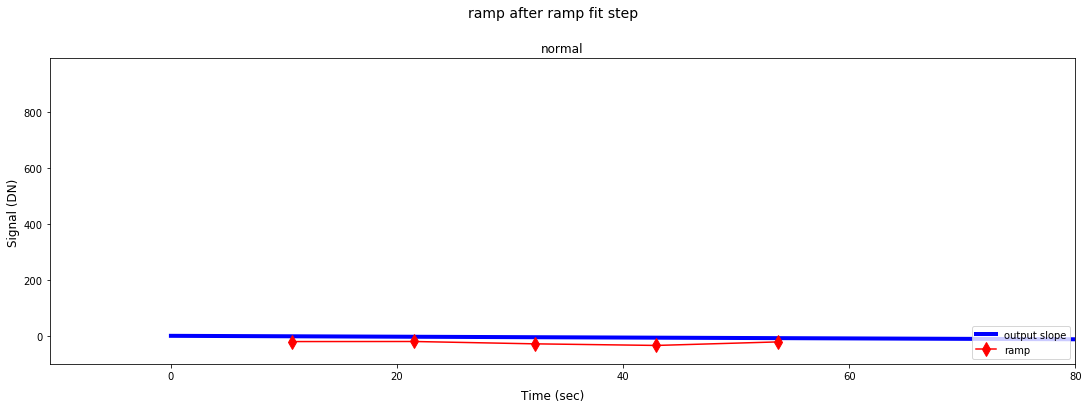

In [81]:
# plot some ramps after ramp fit step

# modify functions slightly
def plot_rate(image, xpix, ypix, title, label, ax, color, ymin, ymax, xmin, xmax,mode):
    nframe = readpatts[mode.lower()]['nframe']
    nskip = readpatts[mode.lower()]['nskip']
    ngroup = readpatts[mode.lower()]['ngroup']
    tgroup = readpatts[mode.lower()]['tgroup']    
    dataloc = (nframe+nskip)/2
    x_ramp =np.arange(0,len(image)*(nframe+nskip),(nframe+nskip))*10.73676
    ax.plot(x_ramp, image[ypix,xpix]*x_ramp, label=label,lw=4,color=color)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin-tgroup,80)#xmax*tgroup+tgroup)
    ax.set_title(title)
    ax.legend(loc=4)
    return ax


def plot_pixel(image, xpix, ypix, title, label, ax, color, ymin, ymax, xmin, xmax,mode):
    nframe = readpatts[mode.lower()]['nframe']
    nskip = readpatts[mode.lower()]['nskip']
    ngroup = readpatts[mode.lower()]['ngroup']
    tgroup = readpatts[mode.lower()]['tgroup']
    dataloc = (nframe+nskip)/1
    ax.plot(np.arange(dataloc,len(image)*(nframe+nskip)+dataloc,(nframe+nskip))*10.73676, image[:,ypix,xpix], label=label, marker='d',markersize=10, color=color)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin-tgroup,80)#xmax*tgroup+tgroup)
    ax.set_title(title)
    ax.legend(loc=4)
    return ax


def plot_ramp(image, xpix, ypix, title, label, ax, color, ymin, ymax, xmin, xmax,mode):
    nframe = readpatts[mode.lower()]['nframe']
    nskip = readpatts[mode.lower()]['nskip']
    ngroup = readpatts[mode.lower()]['ngroup']
    tgroup = readpatts[mode.lower()]['tgroup']    
    dataloc = (nframe+nskip)/2
    x_ramp =np.arange(dataloc,len(image)*(nframe+nskip)+dataloc,(nframe+nskip))*10.73676
    ax.plot(x_ramp, image[ypix,xpix]*x_ramp, label=label,lw=4,color=color)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin-tgroup,80)#xmax*tgroup+tgroup)
    ax.set_title(title)
    ax.legend(loc=4)
    return ax

ymax = ngroups*10.73676*image_ramp[repy,repx]+1000

# simulated data pixels
f, ax1 = plt.subplots(1,1, figsize=(15,5))
ax1 = plot_rate(image_ramp, repx, repy, 'normal','output slope',ax1, 'blue',-100,ymax, 0, 4.0,mode)
ax1 = plot_pixel(image_jump, repx, repy, 'normal','ramp',ax1, 'red',-100,ymax, 0, 4.0,mode)

f.text(0.5, -0.02, 'Time (sec)', ha='center', fontsize=12)
f.text(0.5, 1.04, 'ramp after ramp fit step', ha='center', fontsize=14)
f.text(-0.005, 0.5, 'Signal (DN)', va='center', rotation='vertical', fontsize=12)
f.tight_layout()

In [82]:
# get mean rate
rate_mean,rate_med,rate_std = sigma_clipped_stats(image_ramp,sigma=3)
print('Mean:',rate_mean)
print('Median:',rate_med)
print('Std:',rate_std)

('Mean:', -0.039950864057728332)
('Median:', -0.038351271)
('Std:', 0.16395924181138416)


<module 'matplotlib.pyplot' from '/user/acanipe/miniconda3/envs/jwst71release/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

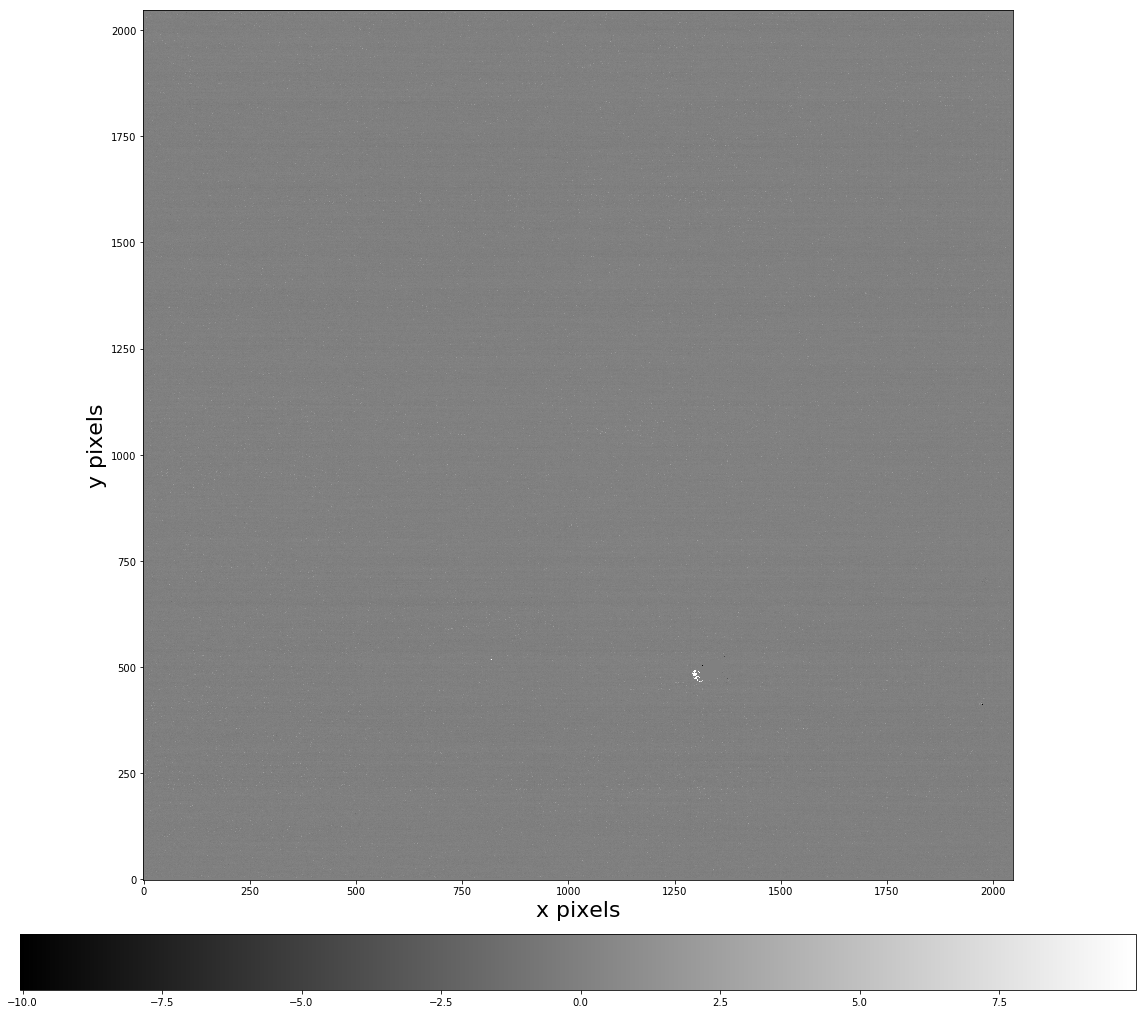

In [83]:
# look at images after ramp fit step 

# simulated image
display_img(image_ramp,rate_mean-10,rate_mean+10)

## Final summary

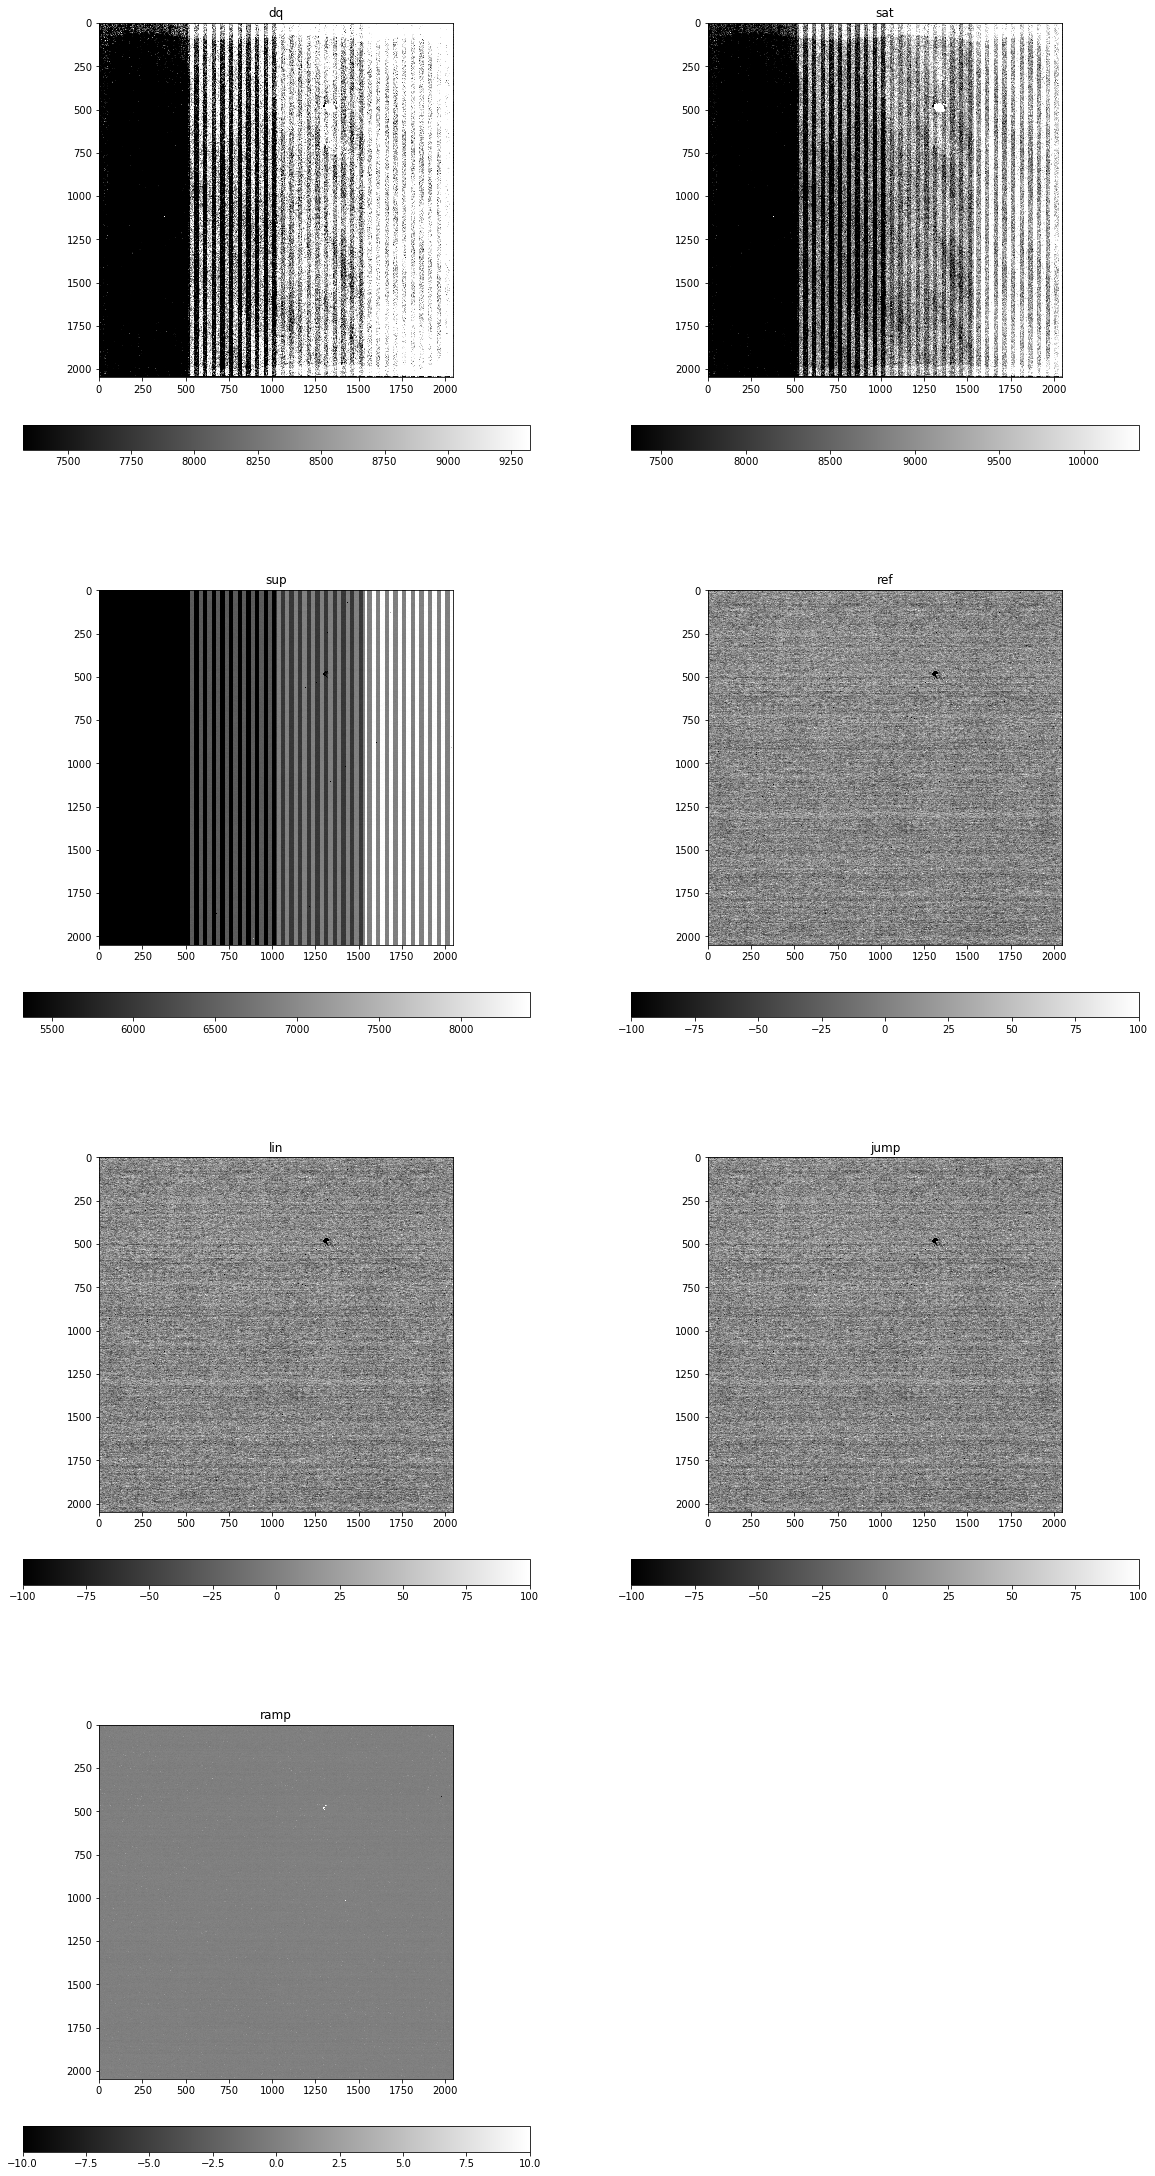

In [110]:
# display images from each step

plt.figure(figsize=(20,40))
columns = 2
titles = ['dq','sat','sup','ref','lin','jump','ramp']
vmins = [mean-1000,mean-1000,mean-3000,-100,-100,-100,-10]
vmaxs = [mean+1000,mean+2000,mean+100,100,100,100,10]
images = [image_dq[0,:,:],image_sat[0,:,:],image_sup[0,:,:],image_ref[0,:,:],image_lin[0,:,:],image_jump[0,:,:],image_ramp]
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image,vmin=vmins[i],vmax=vmaxs[i], cmap=plt.cm.gray)
    plt.colorbar(orientation='horizontal',pad=0.1) 
    plt.title(titles[i])

In [111]:
# summary for pixel

np.set_printoptions(precision=3)
for i in np.arange(0,8):
    if i < 7:
        print('\n\n\n*************')
        print('For step:')
        print(i)
        print(stepname[i])
        print('*************')
        print('\nRep pixel:\n')
        print('image',listout_normpix[i,:])
        print('dqout',grpdqout_normpix[i,:])
        print('err',errout_normpix[i,:])
    if i >= 7:
        print('\n\n\n*************')
        print('For step:')
        print(i)
        print(stepname[i])
        print('*************')
        print('\nRep pixel:\n')
        print('image',listout_normpix[i,0])
        print('dqout',grpdqout_normpix[i,0])
        print('err',errout_normpix[i,0])




*************
For step:
0
['RAW']
*************

Rep pixel:

('image', array([ 9108.,  9103.,  9105.,  9111.,  9105.]))
('dqout', array([ 0.,  0.,  0.,  0.,  0.]))
('err', array([ 0.,  0.,  0.,  0.,  0.]))



*************
For step:
1
['DQ']
*************

Rep pixel:

('image', array([ 9108.,  9103.,  9105.,  9111.,  9105.]))
('dqout', array([ 0.,  0.,  0.,  0.,  0.]))
('err', array([ 0.,  0.,  0.,  0.,  0.]))



*************
For step:
2
['SAT']
*************

Rep pixel:

('image', array([ 9108.,  9103.,  9105.,  9111.,  9105.]))
('dqout', array([ 0.,  0.,  0.,  0.,  0.]))
('err', array([ 0.,  0.,  0.,  0.,  0.]))



*************
For step:
3
['SUP']
*************

Rep pixel:

('image', array([ 5965.29833984,  5960.29833984,  5962.29833984,  5968.29833984,
        5962.29833984]))
('dqout', array([ 0.,  0.,  0.,  0.,  0.]))
('err', array([ 0.,  0.,  0.,  0.,  0.]))



*************
For step:
4
['REFPIX']
*************

Rep pixel:

('image', array([-20.51220703, -20.25500488, -28.67

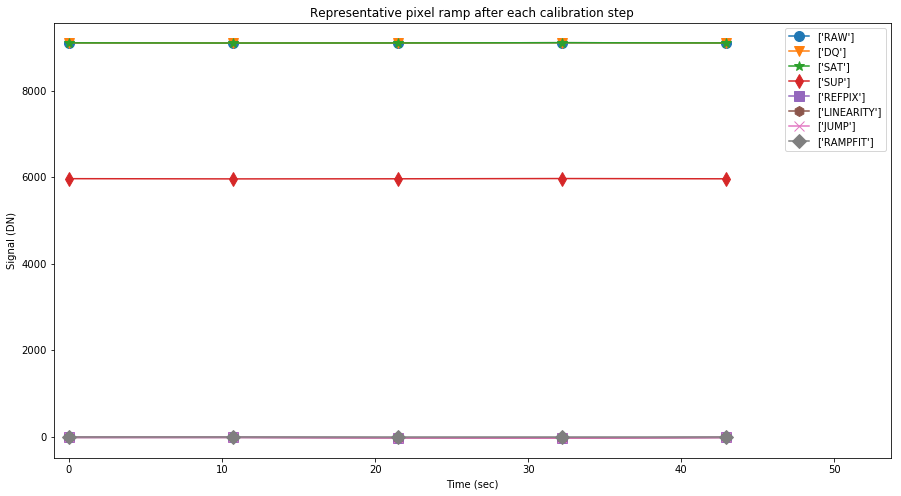

In [116]:
# look at ramps together after each calibration step

fig, normal = plt.subplots(1,1, figsize=(15,8))
markers = ['o','v','*','d','s','h','x','D']
x_group = np.arange(0,ngroups)

for i,mark in zip(np.arange(0,8),markers):
    
    normal.plot(x_group*10.73676,listout_normpix[i,:],label=stepname[i],marker=mark,markersize=10)
    normal.set_title('Representative pixel ramp after each calibration step')
    normal.set_xlabel('Time (sec)')
    normal.set_ylabel('Signal (DN)')
    normal.set_xlim(-1,ngroups*10.73676)
#     normal.set_ylim(-500,10000)
    normal.legend(loc='best',prop={'size':10})

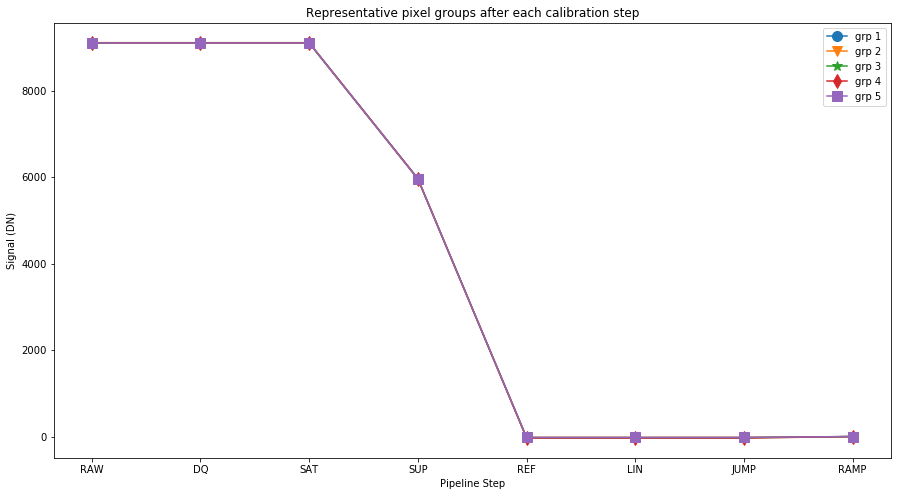

In [118]:
# look at groups together after each calibration step 

fig, normal = plt.subplots(1,1, figsize=(15,8))
markers = ['o','v','*','d','s','h','x','D']
names = ['grp 1', 'grp 2', 'grp 3', 'grp 4', 'grp 5']#
my_xticks = ['RAW','DQ','SAT','SUP','REF','LIN','JUMP','RAMP']
x2 = np.arange(0,len(markers))

# for i in np.arange(0,len(names)):
for j,mark,i in zip(np.arange(0,7),markers,names):

    
    normal.plot(x2,listout_normpix[:,j],label=i,marker=mark,markersize=10)
    normal.set_title('Representative pixel groups after each calibration step')
    normal.set_xticks(x2)
    normal.set_xticklabels(my_xticks)
    normal.set_ylabel('Signal (DN)')
    normal.set_xlabel('Pipeline Step')
#         normal.set_xlim(-1,9)
#         normal.set_ylim(-500,10000)
    normal.legend(loc=1,prop={'size':10})

## A note about multiprocessing

The pipeline itself only accepts a single file. Processing Level-1b (CALDETECTOR1) files can happen independently, you can use multiprocessing to batch-process multiple files. An example code is given below:

In [ ]:
##### multiproc_detector1.py######
from multiprocessing import Pool
from jwst.pipeline import Detector1Pipeline

N_PROCS = 5  # Number of cores available for processing.

def calwebb_detector1(input):
    Detector1Pipeline.call(input, config_file='calwebb_detector1.cfg')

files_to_process = glob('*_uncal.fits')
with Pool(N_PROCS) as pool:
    pool.map(calwebb_detector1, files_to_process)
##### end of multiproc_detector1.py #####